In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/MyDrive/dataset/

/content/drive/MyDrive/dataset


## 1. Setup and Imports

In [3]:
# Import required libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
from tqdm import tqdm
import pandas as pd
from sklearn.metrics import roc_auc_score, roc_curve, auc
import warnings
import json
from datetime import datetime

warnings.filterwarnings('ignore')

# Import model variants
from models.saulite import SAULite, ConfigurableSAULite
from models.sdulite import ULiteDropBlock
from models.sda_ulite import ConfigurableSDAULite
# Add other model imports as needed
# from models.unet18 import UNet18
# from models.saunet import SAUNet

print("Libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Libraries imported successfully!
PyTorch version: 2.8.0+cu126
CUDA available: True
Using device: cuda


## 2. Dataset Configuration and Loading

In [4]:
# Dataset Class
class CHASEDataset(Dataset):
    """Dataset class for CHASE retinal blood vessel segmentation"""

    def __init__(self, image_dir, mask_dir, transform=None, target_size=(256, 256)):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.target_size = target_size

        # Get list of image files
        self.image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.jpg')])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Load image
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_dir, img_name)
        image = Image.open(img_path).convert('RGB')

        # Load mask - CHASE uses _1stHO.png suffix
        mask_name = img_name.replace('.jpg', '_1stHO.png')
        mask_path = os.path.join(self.mask_dir, mask_name)

        if not os.path.exists(mask_path):
            # Try without _1stHO suffix
            mask_name = img_name.replace('.jpg', '.png')
            mask_path = os.path.join(self.mask_dir, mask_name)

        mask = Image.open(mask_path).convert('L')

        # Resize
        image = image.resize(self.target_size, Image.BILINEAR)
        mask = mask.resize(self.target_size, Image.NEAREST)

        # Convert to numpy
        image = np.array(image, dtype=np.float32) / 255.0
        mask = np.array(mask, dtype=np.float32) / 255.0

        # Convert to tensor format (C, H, W)
        image = torch.from_numpy(image.transpose(2, 0, 1))
        mask = torch.from_numpy(mask).unsqueeze(0)

        # Binary mask
        mask = (mask > 0.5).float()

        return image, mask

In [5]:
# Load datasets
BATCH_SIZE = 4
IMAGE_SIZE = (256, 256)

train_dataset = CHASEDataset(
    image_dir='CHASE/train/image',
    mask_dir='CHASE/train/label',
    target_size=IMAGE_SIZE
)

val_dataset = CHASEDataset(
    image_dir='CHASE/validate/images',
    mask_dir='CHASE/validate/labels',
    target_size=IMAGE_SIZE
)

test_dataset = CHASEDataset(
    image_dir='CHASE/test/image',
    mask_dir='CHASE/test/label',
    target_size=IMAGE_SIZE
)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0)

print(f"Dataset loaded successfully!")
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Dataset loaded successfully!
Training samples: 247
Validation samples: 13
Test samples: 8


## 3. Metrics and Loss Functions

In [6]:
# Evaluation Metrics
def dice_coefficient(pred, target, smooth=1e-6):
    """Calculate Dice coefficient"""
    pred = (pred > 0.5).float()
    intersection = (pred * target).sum()
    return (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)

def iou_score(pred, target, smooth=1e-6):
    """Calculate IoU (Intersection over Union)"""
    pred = (pred > 0.5).float()
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection
    return (intersection + smooth) / (union + smooth)

def sensitivity(pred, target, smooth=1e-6):
    """Calculate Sensitivity (Recall/True Positive Rate)"""
    pred = (pred > 0.5).float()
    true_positive = (pred * target).sum()
    false_negative = ((1 - pred) * target).sum()
    return (true_positive + smooth) / (true_positive + false_negative + smooth)

def specificity(pred, target, smooth=1e-6):
    """Calculate Specificity (True Negative Rate)"""
    pred = (pred > 0.5).float()
    true_negative = ((1 - pred) * (1 - target)).sum()
    false_positive = (pred * (1 - target)).sum()
    return (true_negative + smooth) / (true_negative + false_positive + smooth)

def accuracy(pred, target):
    """Calculate Accuracy"""
    pred = (pred > 0.5).float()
    correct = (pred == target).float().sum()
    total = target.numel()
    return correct / total

def f1_score_manual(pred, target, smooth=1e-6):
    """Calculate F1 Score"""
    pred = (pred > 0.5).float()
    true_positive = (pred * target).sum()
    false_positive = (pred * (1 - target)).sum()
    false_negative = ((1 - pred) * target).sum()

    precision = (true_positive + smooth) / (true_positive + false_positive + smooth)
    recall = (true_positive + smooth) / (true_positive + false_negative + smooth)

    f1 = 2 * (precision * recall) / (precision + recall + smooth)
    return f1

def calculate_auc(pred_prob, target):
    """Calculate AUC (Area Under ROC Curve)"""
    pred_prob_flat = pred_prob.cpu().numpy().flatten()
    target_flat = target.cpu().numpy().flatten()

    try:
        auc = roc_auc_score(target_flat, pred_prob_flat)
        return auc
    except:
        return 0.0

def compute_all_metrics(pred_prob, target):
    """Compute all metrics at once"""
    metrics = {
        'dice': dice_coefficient(pred_prob, target).item(),
        'iou': iou_score(pred_prob, target).item(),
        'sensitivity': sensitivity(pred_prob, target).item(),
        'specificity': specificity(pred_prob, target).item(),
        'accuracy': accuracy(pred_prob, target).item(),
        'f1': f1_score_manual(pred_prob, target).item(),
        'auc': calculate_auc(pred_prob, target)
    }
    return metrics

print("Metrics defined successfully!")

Metrics defined successfully!


In [7]:
# Loss Function
class DiceBCELoss(nn.Module):
    """Combined Dice + BCE loss"""
    def __init__(self, dice_weight=0.5):
        super(DiceBCELoss, self).__init__()
        self.dice_weight = dice_weight
        self.bce = nn.BCEWithLogitsLoss()

    def forward(self, pred, target):
        # BCE Loss
        bce_loss = self.bce(pred, target)

        # Dice Loss
        pred_sigmoid = torch.sigmoid(pred)
        intersection = (pred_sigmoid * target).sum()
        dice_loss = 1 - (2. * intersection + 1) / (pred_sigmoid.sum() + target.sum() + 1)

        return self.dice_weight * dice_loss + (1 - self.dice_weight) * bce_loss

print("Loss function defined!")

Loss function defined!


## 4. Model Variant Registry

Define all model variants here. To add a new variant, simply add a new entry to the `MODEL_CONFIGS` dictionary.

In [8]:
# Import additional model variants
from models.saulite import SpatialAttention, EncoderBlock, DecoderBlock, BottleNeckBlockWithSA

# Full SA-U-Lite definition (with attention on all skip connections)
class FullSAULite(nn.Module):
    """SA-U-Lite with spatial attention on ALL skip connections"""

    def __init__(self, input_channel=3, num_classes=1, base_channels=16,
                 activation='gelu', dropout_rate=0.0, attention_kernel_size=7):
        super().__init__()

        # Activation function
        if activation == 'gelu':
            self.act = nn.GELU()
        elif activation == 'relu':
            self.act = nn.ReLU(inplace=True)
        elif activation == 'elu':
            self.act = nn.ELU(inplace=True)
        else:
            self.act = nn.GELU()

        # Encoder
        self.conv_in = nn.Conv2d(input_channel, base_channels, kernel_size=7, padding='same')
        self.e1 = EncoderBlock(base_channels, base_channels * 2)
        self.e2 = EncoderBlock(base_channels * 2, base_channels * 4)
        self.e3 = EncoderBlock(base_channels * 4, base_channels * 8)
        self.e4 = EncoderBlock(base_channels * 8, base_channels * 16)
        self.e5 = EncoderBlock(base_channels * 16, base_channels * 32)

        # Bottleneck with Spatial Attention
        self.b5 = BottleNeckBlockWithSA(base_channels * 32, attention_kernel_size=attention_kernel_size)

        # Decoder
        self.d5 = DecoderBlock(base_channels * 32, base_channels * 16)
        self.d4 = DecoderBlock(base_channels * 16, base_channels * 8)
        self.d3 = DecoderBlock(base_channels * 8, base_channels * 4)
        self.d2 = DecoderBlock(base_channels * 4, base_channels * 2)
        self.d1 = DecoderBlock(base_channels * 2, base_channels)

        # Dropout
        self.dropout = nn.Dropout2d(dropout_rate) if dropout_rate > 0 else nn.Identity()

        self.conv_out = nn.Conv2d(base_channels, num_classes, kernel_size=1)

        # Spatial Attention Module
        self.spatial_attention = SpatialAttention(kernel_size=attention_kernel_size)

    def forward(self, x):
        # Encoder
        x = self.conv_in(x)
        x, skip1 = self.e1(x)
        x, skip2 = self.e2(x)
        x, skip3 = self.e3(x)
        x, skip4 = self.e4(x)
        x, skip5 = self.e5(x)

        # Bottleneck with Spatial Attention
        x = self.b5(x)

        # Decoder with attention on all skip connections
        skip5 = self.spatial_attention(skip5)
        x = self.d5(x, skip5)

        skip4 = self.spatial_attention(skip4)
        x = self.d4(x, skip4)

        skip3 = self.spatial_attention(skip3)
        x = self.d3(x, skip3)

        skip2 = self.spatial_attention(skip2)
        x = self.d2(x, skip2)

        skip1 = self.spatial_attention(skip1)
        x = self.d1(x, skip1)

        # Dropout and output
        x = self.dropout(x)
        x = self.conv_out(x)
        return x

print("Model variants defined!")

Model variants defined!


In [20]:
# Model Configuration Registry
# To add a new variant, add an entry here with the model class and its hyperparameters

MODEL_CONFIGS = {
    'SA-U-Lite': {
        'class': ConfigurableSAULite,
        'params': {
            'input_channel': 3,
            'num_classes': 1,
            'base_channels': 16,
            'activation': 'gelu',
            'dropout_rate': 0.1,
            'attention_kernel_size': 7
        },
        'description': 'Spatial Attention ONLY in bottleneck',
        'color': 'steelblue'
    },

    'Full-SA-U-Lite': {
        'class': FullSAULite,
        'params': {
            'input_channel': 3,
            'num_classes': 1,
            'base_channels': 16,
            'activation': 'gelu',
            'dropout_rate': 0.1,
            'attention_kernel_size': 7
        },
        'description': 'Spatial Attention in bottleneck + ALL skip connections',
        'color': 'darkorange'
    },

    'ULiteDropBlock': {
        'class': ULiteDropBlock,
        'params': {
            'input_channel': 3,
            'num_classes': 1,
            'base_channels': 16,
            'activation': 'gelu',
            'dropout_rate': 0.1,
            'block_size': 7,
            'keep_prob': 0.9
        },
        'description': 'U-Lite with DropBlock regularization',
        'color': 'purple'
    },

    'SDA-U-Lite': {
    'class': ConfigurableSDAULite,
    'params': {
        'input_channel': 3,
        'num_classes': 1,
        'base_channels': 16,
        'block_size': 7,
        'keep_prob': 0.9,
        'attention_kernel_size': 7,
        'activation': 'gelu',
        'dropout_rate': 0.1
    },
    'description': 'U-Lite with Spatial Attention + DropBlock (Most Advanced)',
    'color': 'darkviolet'
    },
    # Add more variants here:
    # 'SA-U-Lite-Large': {
    #     'class': ConfigurableSAULite,
    #     'params': {
    #         'input_channel': 3,
    #         'num_classes': 1,
    #         'base_channels': 32,  # Larger capacity
    #         'activation': 'gelu',
    #         'dropout_rate': 0.1,
    #         'attention_kernel_size': 7
    #     },
    #     'description': 'SA-U-Lite with larger base channels',
    #     'color': 'green'
    # },
}

print(f"Model registry created with {len(MODEL_CONFIGS)} variants:")
for name, config in MODEL_CONFIGS.items():
    print(f"  - {name}: {config['description']}")

Model registry created with 4 variants:
  - SA-U-Lite: Spatial Attention ONLY in bottleneck
  - Full-SA-U-Lite: Spatial Attention in bottleneck + ALL skip connections
  - ULiteDropBlock: U-Lite with DropBlock regularization
  - SDA-U-Lite: U-Lite with Spatial Attention + DropBlock (Most Advanced)


## 5. Training and Evaluation Pipeline

In [21]:
# Training Functions
def train_epoch(model, train_loader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    total_loss = 0
    total_dice = 0

    for images, masks in tqdm(train_loader, desc="Training", leave=False):
        images, masks = images.to(device), masks.to(device)

        # Forward pass
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Metrics
        total_loss += loss.item()
        with torch.no_grad():
            pred_sigmoid = torch.sigmoid(outputs)
            total_dice += dice_coefficient(pred_sigmoid, masks).item()

    avg_loss = total_loss / len(train_loader)
    avg_dice = total_dice / len(train_loader)

    return avg_loss, avg_dice

def validate(model, val_loader, criterion, device):
    """Validate the model with comprehensive metrics"""
    model.eval()
    total_loss = 0
    metrics_sum = {
        'dice': 0, 'iou': 0, 'sensitivity': 0,
        'specificity': 0, 'accuracy': 0, 'f1': 0, 'auc': 0
    }

    with torch.no_grad():
        for images, masks in tqdm(val_loader, desc="Validation", leave=False):
            images, masks = images.to(device), masks.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, masks)
            total_loss += loss.item()

            # Metrics
            pred_sigmoid = torch.sigmoid(outputs)
            batch_metrics = compute_all_metrics(pred_sigmoid, masks)

            for key in metrics_sum:
                metrics_sum[key] += batch_metrics[key]

    # Average metrics
    num_batches = len(val_loader)
    avg_metrics = {key: val / num_batches for key, val in metrics_sum.items()}
    avg_loss = total_loss / num_batches

    return avg_loss, avg_metrics

def evaluate_test_set(model, test_loader, device):
    """Evaluate model on test set"""
    model.eval()
    test_metrics = {
        'dice': [], 'iou': [], 'sensitivity': [], 'specificity': [],
        'accuracy': [], 'f1': [], 'auc': []
    }

    with torch.no_grad():
        for images, masks in tqdm(test_loader, desc="Testing", leave=False):
            images, masks = images.to(device), masks.to(device)

            # Forward pass
            outputs = model(images)
            pred_sigmoid = torch.sigmoid(outputs)

            # Calculate all metrics
            batch_metrics = compute_all_metrics(pred_sigmoid, masks)

            for key in test_metrics:
                test_metrics[key].append(batch_metrics[key])

    # Calculate statistics
    test_stats = {}
    for metric_name, values in test_metrics.items():
        test_stats[metric_name] = {
            'mean': np.mean(values),
            'std': np.std(values),
            'min': np.min(values),
            'max': np.max(values)
        }

    return test_stats, test_metrics

print("Training and evaluation functions defined!")

Training and evaluation functions defined!


In [22]:
# Automated Training Pipeline
def train_model_variant(model_name, model_config, num_epochs=50, lr=0.001, save_dir='model_checkpoints'):
    """
    Train a model variant with the given configuration

    Args:
        model_name: Name of the model variant
        model_config: Configuration dictionary with 'class' and 'params'
        num_epochs: Number of training epochs
        lr: Learning rate
        save_dir: Directory to save checkpoints

    Returns:
        Dictionary with training history and test results
    """
    print("\n" + "="*80)
    print(f"Training: {model_name}")
    print(f"Description: {model_config['description']}")
    print("="*80)

    # Create model
    model = model_config['class'](**model_config['params']).to(device)
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total parameters: {total_params:,}")

    # Setup training
    criterion = DiceBCELoss(dice_weight=0.5)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5)

    # Training history
    history = {
        'train_loss': [],
        'train_dice': [],
        'val_loss': [],
        'val_metrics': []
    }

    best_dice = 0.0
    os.makedirs(save_dir, exist_ok=True)
    checkpoint_path = os.path.join(save_dir, f'{model_name.replace(" ", "_")}_best.pth')

    # Training loop
    for epoch in range(num_epochs):
        print(f"\nEpoch [{epoch+1}/{num_epochs}]")

        # Train
        train_loss, train_dice = train_epoch(model, train_loader, criterion, optimizer, device)

        # Validate
        val_loss, val_metrics = validate(model, val_loader, criterion, device)

        # Learning rate scheduling
        scheduler.step(val_metrics['dice'])

        # Save history
        history['train_loss'].append(train_loss)
        history['train_dice'].append(train_dice)
        history['val_loss'].append(val_loss)
        history['val_metrics'].append(val_metrics)

        # Print metrics
        print(f"  Train Loss: {train_loss:.4f}, Train Dice: {train_dice:.4f}")
        print(f"  Val Loss: {val_loss:.4f}, Val Dice: {val_metrics['dice']:.4f}")

        # Save best model
        if val_metrics['dice'] > best_dice:
            best_dice = val_metrics['dice']
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_metrics': val_metrics,
                'model_config': model_config,
            }, checkpoint_path)
            print(f"  ✓ Best model saved! (Dice: {best_dice:.4f})")

    # Load best model and evaluate on test set
    checkpoint = torch.load(checkpoint_path, weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])

    print("\nEvaluating on test set...")
    test_stats, test_metrics_raw = evaluate_test_set(model, test_loader, device)

    results = {
        'model_name': model_name,
        'total_params': total_params,
        'history': history,
        'best_val_dice': best_dice,
        'test_stats': test_stats,
        'test_metrics_raw': test_metrics_raw,
        'checkpoint_path': checkpoint_path
    }

    print("\n" + "="*80)
    print(f"Training completed for {model_name}")
    print(f"Best validation Dice: {best_dice:.4f}")
    print(f"Test Dice: {test_stats['dice']['mean']:.4f} \u00b1 {test_stats['dice']['std']:.4f}")
    print("="*80)

    return results

## 6. Train All Model Variants

This section trains all models defined in the registry. You can modify the list `models_to_train` to select specific variants.

In [44]:
# Training Configuration
TRAINING_CONFIG = {
    'num_epochs': 150,
    'learning_rate': 0.001,
    'save_dir': 'model_checkpoints'
}

# Select which models to train (or train all)
models_to_train = list(MODEL_CONFIGS.keys())  # Train all models
# models_to_train = ['SA-U-Lite', 'Full-SA-U-Lite']  # Or select specific ones

print(f"Will train {len(models_to_train)} model variant(s):")
for name in models_to_train:
    print(f"  - {name}")

Will train 4 model variant(s):
  - SA-U-Lite
  - Full-SA-U-Lite
  - ULiteDropBlock
  - SDA-U-Lite


In [45]:
# Train all selected models
all_results = {}

for model_name in models_to_train:
    if model_name in MODEL_CONFIGS:
        results = train_model_variant(
            model_name=model_name,
            model_config=MODEL_CONFIGS[model_name],
            num_epochs=TRAINING_CONFIG['num_epochs'],
            lr=TRAINING_CONFIG['learning_rate'],
            save_dir=TRAINING_CONFIG['save_dir']
        )
        all_results[model_name] = results
    else:
        print(f"Warning: Model '{model_name}' not found in registry!")

print("\n" + "="*80)
print("ALL TRAINING COMPLETED!")
print("="*80)


Training: SA-U-Lite
Description: Spatial Attention ONLY in bottleneck
Total parameters: 878,515

Epoch [1/150]


  Train Loss: 0.5956, Train Dice: 0.4570
  Val Loss: 0.4059, Val Dice: 0.5680
  ✓ Best model saved! (Dice: 0.5680)

Epoch [2/150]


  Train Loss: 0.3260, Train Dice: 0.6294
  Val Loss: 0.2751, Val Dice: 0.6341
  ✓ Best model saved! (Dice: 0.6341)

Epoch [3/150]


  Train Loss: 0.2631, Train Dice: 0.6795
  Val Loss: 0.2331, Val Dice: 0.7125
  ✓ Best model saved! (Dice: 0.7125)

Epoch [4/150]


  Train Loss: 0.2335, Train Dice: 0.7094
  Val Loss: 0.2163, Val Dice: 0.7320
  ✓ Best model saved! (Dice: 0.7320)

Epoch [5/150]


  Train Loss: 0.2232, Train Dice: 0.7228
  Val Loss: 0.2078, Val Dice: 0.7395
  ✓ Best model saved! (Dice: 0.7395)

Epoch [6/150]


  Train Loss: 0.2142, Train Dice: 0.7338
  Val Loss: 0.2175, Val Dice: 0.7248

Epoch [7/150]


  Train Loss: 0.2065, Train Dice: 0.7440
  Val Loss: 0.1983, Val Dice: 0.7571
  ✓ Best model saved! (Dice: 0.7571)

Epoch [8/150]


  Train Loss: 0.1980, Train Dice: 0.7545
  Val Loss: 0.1950, Val Dice: 0.7609
  ✓ Best model saved! (Dice: 0.7609)

Epoch [9/150]


  Train Loss: 0.1959, Train Dice: 0.7587
  Val Loss: 0.1935, Val Dice: 0.7650
  ✓ Best model saved! (Dice: 0.7650)

Epoch [10/150]


  Train Loss: 0.1874, Train Dice: 0.7676
  Val Loss: 0.1887, Val Dice: 0.7698
  ✓ Best model saved! (Dice: 0.7698)

Epoch [11/150]


  Train Loss: 0.1812, Train Dice: 0.7762
  Val Loss: 0.1897, Val Dice: 0.7656

Epoch [12/150]


  Train Loss: 0.1769, Train Dice: 0.7817
  Val Loss: 0.1843, Val Dice: 0.7759
  ✓ Best model saved! (Dice: 0.7759)

Epoch [13/150]


  Train Loss: 0.1750, Train Dice: 0.7867
  Val Loss: 0.1835, Val Dice: 0.7750

Epoch [14/150]


  Train Loss: 0.1686, Train Dice: 0.7931
  Val Loss: 0.1870, Val Dice: 0.7741

Epoch [15/150]


  Train Loss: 0.1631, Train Dice: 0.8004
  Val Loss: 0.1808, Val Dice: 0.7774
  ✓ Best model saved! (Dice: 0.7774)

Epoch [16/150]


  Train Loss: 0.1600, Train Dice: 0.8036
  Val Loss: 0.1802, Val Dice: 0.7821
  ✓ Best model saved! (Dice: 0.7821)

Epoch [17/150]


  Train Loss: 0.1557, Train Dice: 0.8099
  Val Loss: 0.1833, Val Dice: 0.7767

Epoch [18/150]


  Train Loss: 0.1532, Train Dice: 0.8121
  Val Loss: 0.1791, Val Dice: 0.7841
  ✓ Best model saved! (Dice: 0.7841)

Epoch [19/150]


  Train Loss: 0.1496, Train Dice: 0.8173
  Val Loss: 0.1790, Val Dice: 0.7839

Epoch [20/150]


  Train Loss: 0.1451, Train Dice: 0.8243
  Val Loss: 0.1794, Val Dice: 0.7818

Epoch [21/150]


  Train Loss: 0.1435, Train Dice: 0.8253
  Val Loss: 0.1822, Val Dice: 0.7802

Epoch [22/150]


  Train Loss: 0.1423, Train Dice: 0.8273
  Val Loss: 0.1777, Val Dice: 0.7865
  ✓ Best model saved! (Dice: 0.7865)

Epoch [23/150]


  Train Loss: 0.1383, Train Dice: 0.8324
  Val Loss: 0.1775, Val Dice: 0.7887
  ✓ Best model saved! (Dice: 0.7887)

Epoch [24/150]


  Train Loss: 0.1349, Train Dice: 0.8372
  Val Loss: 0.1791, Val Dice: 0.7856

Epoch [25/150]


  Train Loss: 0.1312, Train Dice: 0.8410
  Val Loss: 0.1743, Val Dice: 0.7907
  ✓ Best model saved! (Dice: 0.7907)

Epoch [26/150]


  Train Loss: 0.1279, Train Dice: 0.8458
  Val Loss: 0.1783, Val Dice: 0.7899

Epoch [27/150]


  Train Loss: 0.1260, Train Dice: 0.8487
  Val Loss: 0.1809, Val Dice: 0.7851

Epoch [28/150]


  Train Loss: 0.1246, Train Dice: 0.8498
  Val Loss: 0.1796, Val Dice: 0.7846

Epoch [29/150]


  Train Loss: 0.1233, Train Dice: 0.8517
  Val Loss: 0.1771, Val Dice: 0.7886

Epoch [30/150]


  Train Loss: 0.1206, Train Dice: 0.8552
  Val Loss: 0.1760, Val Dice: 0.7909
  ✓ Best model saved! (Dice: 0.7909)

Epoch [31/150]


  Train Loss: 0.1191, Train Dice: 0.8568
  Val Loss: 0.1798, Val Dice: 0.7873

Epoch [32/150]


  Train Loss: 0.1166, Train Dice: 0.8600
  Val Loss: 0.1751, Val Dice: 0.7939
  ✓ Best model saved! (Dice: 0.7939)

Epoch [33/150]


  Train Loss: 0.1136, Train Dice: 0.8639
  Val Loss: 0.1801, Val Dice: 0.7871

Epoch [34/150]


  Train Loss: 0.1133, Train Dice: 0.8639
  Val Loss: 0.1767, Val Dice: 0.7915

Epoch [35/150]


  Train Loss: 0.1133, Train Dice: 0.8638
  Val Loss: 0.1743, Val Dice: 0.7937

Epoch [36/150]


  Train Loss: 0.1107, Train Dice: 0.8679
  Val Loss: 0.1744, Val Dice: 0.7979
  ✓ Best model saved! (Dice: 0.7979)

Epoch [37/150]


  Train Loss: 0.1069, Train Dice: 0.8723
  Val Loss: 0.1766, Val Dice: 0.7949

Epoch [38/150]


  Train Loss: 0.1070, Train Dice: 0.8720
  Val Loss: 0.1775, Val Dice: 0.7928

Epoch [39/150]


  Train Loss: 0.1073, Train Dice: 0.8712
  Val Loss: 0.1787, Val Dice: 0.7932

Epoch [40/150]


  Train Loss: 0.1038, Train Dice: 0.8762
  Val Loss: 0.1785, Val Dice: 0.7929

Epoch [41/150]


  Train Loss: 0.1027, Train Dice: 0.8777
  Val Loss: 0.1761, Val Dice: 0.7958

Epoch [42/150]


  Train Loss: 0.1024, Train Dice: 0.8785
  Val Loss: 0.1764, Val Dice: 0.7960

Epoch [43/150]


  Train Loss: 0.0959, Train Dice: 0.8869
  Val Loss: 0.1750, Val Dice: 0.7997
  ✓ Best model saved! (Dice: 0.7997)

Epoch [44/150]


  Train Loss: 0.0923, Train Dice: 0.8927
  Val Loss: 0.1772, Val Dice: 0.7927

Epoch [45/150]


  Train Loss: 0.0891, Train Dice: 0.8963
  Val Loss: 0.1797, Val Dice: 0.7989

Epoch [46/150]


  Train Loss: 0.0875, Train Dice: 0.8988
  Val Loss: 0.1786, Val Dice: 0.8012
  ✓ Best model saved! (Dice: 0.8012)

Epoch [47/150]


  Train Loss: 0.0872, Train Dice: 0.8989
  Val Loss: 0.1810, Val Dice: 0.7978

Epoch [48/150]


  Train Loss: 0.0859, Train Dice: 0.9008
  Val Loss: 0.1814, Val Dice: 0.7988

Epoch [49/150]


  Train Loss: 0.0854, Train Dice: 0.9015
  Val Loss: 0.1833, Val Dice: 0.7969

Epoch [50/150]


  Train Loss: 0.0856, Train Dice: 0.9017
  Val Loss: 0.1824, Val Dice: 0.7964

Epoch [51/150]


  Train Loss: 0.0850, Train Dice: 0.9016
  Val Loss: 0.1818, Val Dice: 0.7987

Epoch [52/150]


  Train Loss: 0.0847, Train Dice: 0.9021
  Val Loss: 0.1811, Val Dice: 0.7994

Epoch [53/150]


  Train Loss: 0.0810, Train Dice: 0.9074
  Val Loss: 0.1816, Val Dice: 0.7992

Epoch [54/150]


  Train Loss: 0.0779, Train Dice: 0.9119
  Val Loss: 0.1817, Val Dice: 0.7995

Epoch [55/150]


  Train Loss: 0.0777, Train Dice: 0.9123
  Val Loss: 0.1843, Val Dice: 0.7961

Epoch [56/150]


  Train Loss: 0.0765, Train Dice: 0.9137
  Val Loss: 0.1843, Val Dice: 0.7988

Epoch [57/150]


  Train Loss: 0.0763, Train Dice: 0.9141
  Val Loss: 0.1835, Val Dice: 0.7995

Epoch [58/150]


  Train Loss: 0.0751, Train Dice: 0.9156
  Val Loss: 0.1846, Val Dice: 0.7987

Epoch [59/150]


  Train Loss: 0.0747, Train Dice: 0.9175
  Val Loss: 0.1847, Val Dice: 0.7991

Epoch [60/150]


  Train Loss: 0.0735, Train Dice: 0.9184
  Val Loss: 0.1860, Val Dice: 0.7990

Epoch [61/150]


  Train Loss: 0.0729, Train Dice: 0.9194
  Val Loss: 0.1869, Val Dice: 0.8004

Epoch [62/150]


  Train Loss: 0.0719, Train Dice: 0.9203
  Val Loss: 0.1872, Val Dice: 0.7999

Epoch [63/150]


  Train Loss: 0.0718, Train Dice: 0.9207
  Val Loss: 0.1873, Val Dice: 0.8001

Epoch [64/150]


  Train Loss: 0.0736, Train Dice: 0.9195
  Val Loss: 0.1866, Val Dice: 0.7996

Epoch [65/150]


  Train Loss: 0.0713, Train Dice: 0.9216
  Val Loss: 0.1868, Val Dice: 0.7997

Epoch [66/150]


  Train Loss: 0.0705, Train Dice: 0.9229
  Val Loss: 0.1889, Val Dice: 0.7990

Epoch [67/150]


  Train Loss: 0.0703, Train Dice: 0.9228
  Val Loss: 0.1895, Val Dice: 0.7992

Epoch [68/150]


  Train Loss: 0.0706, Train Dice: 0.9233
  Val Loss: 0.1885, Val Dice: 0.7989

Epoch [69/150]


  Train Loss: 0.0699, Train Dice: 0.9234
  Val Loss: 0.1888, Val Dice: 0.7998

Epoch [70/150]


  Train Loss: 0.0698, Train Dice: 0.9234
  Val Loss: 0.1893, Val Dice: 0.7969

Epoch [71/150]


  Train Loss: 0.0694, Train Dice: 0.9242
  Val Loss: 0.1917, Val Dice: 0.7990

Epoch [72/150]


  Train Loss: 0.0690, Train Dice: 0.9248
  Val Loss: 0.1870, Val Dice: 0.7993

Epoch [73/150]


  Train Loss: 0.0706, Train Dice: 0.9246
  Val Loss: 0.1901, Val Dice: 0.7984

Epoch [74/150]


  Train Loss: 0.0687, Train Dice: 0.9252
  Val Loss: 0.1902, Val Dice: 0.7997

Epoch [75/150]


  Train Loss: 0.0685, Train Dice: 0.9252
  Val Loss: 0.1895, Val Dice: 0.7995

Epoch [76/150]


  Train Loss: 0.0689, Train Dice: 0.9252
  Val Loss: 0.1903, Val Dice: 0.7980

Epoch [77/150]


  Train Loss: 0.0688, Train Dice: 0.9255
  Val Loss: 0.1902, Val Dice: 0.7992

Epoch [78/150]


  Train Loss: 0.0688, Train Dice: 0.9253
  Val Loss: 0.1902, Val Dice: 0.7986

Epoch [79/150]


  Train Loss: 0.0686, Train Dice: 0.9254
  Val Loss: 0.1882, Val Dice: 0.7971

Epoch [80/150]


  Train Loss: 0.0686, Train Dice: 0.9255
  Val Loss: 0.1910, Val Dice: 0.7979

Epoch [81/150]


  Train Loss: 0.0677, Train Dice: 0.9265
  Val Loss: 0.1898, Val Dice: 0.7984

Epoch [82/150]


  Train Loss: 0.0682, Train Dice: 0.9261
  Val Loss: 0.1902, Val Dice: 0.7990

Epoch [83/150]


  Train Loss: 0.0684, Train Dice: 0.9260
  Val Loss: 0.1910, Val Dice: 0.7989

Epoch [84/150]


  Train Loss: 0.0681, Train Dice: 0.9258
  Val Loss: 0.1903, Val Dice: 0.7988

Epoch [85/150]


  Train Loss: 0.0677, Train Dice: 0.9265
  Val Loss: 0.1899, Val Dice: 0.7972

Epoch [86/150]


  Train Loss: 0.0679, Train Dice: 0.9262
  Val Loss: 0.1915, Val Dice: 0.7980

Epoch [87/150]


  Train Loss: 0.0686, Train Dice: 0.9257
  Val Loss: 0.1919, Val Dice: 0.7984

Epoch [88/150]


  Train Loss: 0.0682, Train Dice: 0.9263
  Val Loss: 0.1911, Val Dice: 0.7982

Epoch [89/150]


  Train Loss: 0.0679, Train Dice: 0.9263
  Val Loss: 0.1903, Val Dice: 0.7995

Epoch [90/150]


  Train Loss: 0.0681, Train Dice: 0.9263
  Val Loss: 0.1906, Val Dice: 0.7975

Epoch [91/150]


  Train Loss: 0.0677, Train Dice: 0.9266
  Val Loss: 0.1914, Val Dice: 0.7986

Epoch [92/150]


  Train Loss: 0.0678, Train Dice: 0.9265
  Val Loss: 0.1897, Val Dice: 0.7990

Epoch [93/150]


  Train Loss: 0.0686, Train Dice: 0.9254
  Val Loss: 0.1897, Val Dice: 0.7980

Epoch [94/150]


  Train Loss: 0.0675, Train Dice: 0.9267
  Val Loss: 0.1907, Val Dice: 0.7991

Epoch [95/150]


  Train Loss: 0.0677, Train Dice: 0.9267
  Val Loss: 0.1911, Val Dice: 0.7989

Epoch [96/150]


  Train Loss: 0.0678, Train Dice: 0.9262
  Val Loss: 0.1910, Val Dice: 0.7977

Epoch [97/150]


  Train Loss: 0.0673, Train Dice: 0.9272
  Val Loss: 0.1910, Val Dice: 0.7992

Epoch [98/150]


  Train Loss: 0.0679, Train Dice: 0.9267
  Val Loss: 0.1914, Val Dice: 0.7986

Epoch [99/150]


  Train Loss: 0.0683, Train Dice: 0.9260
  Val Loss: 0.1925, Val Dice: 0.7993

Epoch [100/150]


  Train Loss: 0.0677, Train Dice: 0.9267
  Val Loss: 0.1895, Val Dice: 0.7978

Epoch [101/150]


  Train Loss: 0.0680, Train Dice: 0.9266
  Val Loss: 0.1908, Val Dice: 0.7992

Epoch [102/150]


  Train Loss: 0.0676, Train Dice: 0.9269
  Val Loss: 0.1900, Val Dice: 0.7984

Epoch [103/150]


  Train Loss: 0.0684, Train Dice: 0.9261
  Val Loss: 0.1923, Val Dice: 0.7988

Epoch [104/150]


  Train Loss: 0.0676, Train Dice: 0.9269
  Val Loss: 0.1911, Val Dice: 0.7986

Epoch [105/150]


  Train Loss: 0.0678, Train Dice: 0.9270
  Val Loss: 0.1889, Val Dice: 0.7987

Epoch [106/150]


  Train Loss: 0.0683, Train Dice: 0.9263
  Val Loss: 0.1908, Val Dice: 0.7985

Epoch [107/150]


  Train Loss: 0.0678, Train Dice: 0.9265
  Val Loss: 0.1916, Val Dice: 0.7982

Epoch [108/150]


  Train Loss: 0.0678, Train Dice: 0.9270
  Val Loss: 0.1925, Val Dice: 0.7977

Epoch [109/150]


  Train Loss: 0.0675, Train Dice: 0.9269
  Val Loss: 0.1893, Val Dice: 0.7968

Epoch [110/150]


  Train Loss: 0.0681, Train Dice: 0.9265
  Val Loss: 0.1917, Val Dice: 0.7986

Epoch [111/150]


  Train Loss: 0.0678, Train Dice: 0.9268
  Val Loss: 0.1908, Val Dice: 0.7989

Epoch [112/150]


  Train Loss: 0.0676, Train Dice: 0.9268
  Val Loss: 0.1908, Val Dice: 0.7981

Epoch [113/150]


  Train Loss: 0.0675, Train Dice: 0.9267
  Val Loss: 0.1911, Val Dice: 0.7999

Epoch [114/150]


  Train Loss: 0.0676, Train Dice: 0.9267
  Val Loss: 0.1909, Val Dice: 0.7976

Epoch [115/150]


  Train Loss: 0.0700, Train Dice: 0.9254
  Val Loss: 0.1910, Val Dice: 0.7981

Epoch [116/150]


  Train Loss: 0.0676, Train Dice: 0.9269
  Val Loss: 0.1918, Val Dice: 0.7982

Epoch [117/150]


  Train Loss: 0.0678, Train Dice: 0.9264
  Val Loss: 0.1902, Val Dice: 0.7983

Epoch [118/150]


  Train Loss: 0.0678, Train Dice: 0.9270
  Val Loss: 0.1904, Val Dice: 0.7982

Epoch [119/150]


  Train Loss: 0.0681, Train Dice: 0.9262
  Val Loss: 0.1917, Val Dice: 0.7979

Epoch [120/150]


  Train Loss: 0.0678, Train Dice: 0.9264
  Val Loss: 0.1919, Val Dice: 0.7983

Epoch [121/150]


  Train Loss: 0.0679, Train Dice: 0.9267
  Val Loss: 0.1911, Val Dice: 0.7988

Epoch [122/150]


  Train Loss: 0.0683, Train Dice: 0.9262
  Val Loss: 0.1906, Val Dice: 0.7977

Epoch [123/150]


  Train Loss: 0.0676, Train Dice: 0.9268
  Val Loss: 0.1899, Val Dice: 0.7985

Epoch [124/150]


  Train Loss: 0.0678, Train Dice: 0.9268
  Val Loss: 0.1898, Val Dice: 0.7969

Epoch [125/150]


  Train Loss: 0.0674, Train Dice: 0.9271
  Val Loss: 0.1914, Val Dice: 0.7987

Epoch [126/150]


  Train Loss: 0.0677, Train Dice: 0.9266
  Val Loss: 0.1911, Val Dice: 0.7993

Epoch [127/150]


  Train Loss: 0.0684, Train Dice: 0.9263
  Val Loss: 0.1905, Val Dice: 0.7987

Epoch [128/150]


  Train Loss: 0.0685, Train Dice: 0.9258
  Val Loss: 0.1912, Val Dice: 0.7974

Epoch [129/150]


  Train Loss: 0.0676, Train Dice: 0.9269
  Val Loss: 0.1925, Val Dice: 0.7979

Epoch [130/150]


  Train Loss: 0.0674, Train Dice: 0.9273
  Val Loss: 0.1908, Val Dice: 0.7988

Epoch [131/150]


  Train Loss: 0.0675, Train Dice: 0.9272
  Val Loss: 0.1916, Val Dice: 0.7976

Epoch [132/150]


  Train Loss: 0.0678, Train Dice: 0.9270
  Val Loss: 0.1914, Val Dice: 0.7990

Epoch [133/150]


  Train Loss: 0.0678, Train Dice: 0.9265
  Val Loss: 0.1908, Val Dice: 0.7988

Epoch [134/150]


  Train Loss: 0.0679, Train Dice: 0.9268
  Val Loss: 0.1911, Val Dice: 0.7984

Epoch [135/150]


  Train Loss: 0.0680, Train Dice: 0.9266
  Val Loss: 0.1901, Val Dice: 0.7974

Epoch [136/150]


  Train Loss: 0.0677, Train Dice: 0.9267
  Val Loss: 0.1897, Val Dice: 0.7980

Epoch [137/150]


  Train Loss: 0.0678, Train Dice: 0.9268
  Val Loss: 0.1891, Val Dice: 0.7978

Epoch [138/150]


  Train Loss: 0.0675, Train Dice: 0.9266
  Val Loss: 0.1896, Val Dice: 0.7965

Epoch [139/150]


  Train Loss: 0.0672, Train Dice: 0.9274
  Val Loss: 0.1913, Val Dice: 0.7974

Epoch [140/150]


  Train Loss: 0.0675, Train Dice: 0.9267
  Val Loss: 0.1908, Val Dice: 0.7993

Epoch [141/150]


  Train Loss: 0.0731, Train Dice: 0.9257
  Val Loss: 0.1927, Val Dice: 0.7983

Epoch [142/150]


  Train Loss: 0.0673, Train Dice: 0.9272
  Val Loss: 0.1903, Val Dice: 0.7985

Epoch [143/150]


  Train Loss: 0.0678, Train Dice: 0.9267
  Val Loss: 0.1899, Val Dice: 0.7984

Epoch [144/150]


  Train Loss: 0.0679, Train Dice: 0.9266
  Val Loss: 0.1923, Val Dice: 0.7987

Epoch [145/150]


  Train Loss: 0.0685, Train Dice: 0.9263
  Val Loss: 0.1901, Val Dice: 0.7982

Epoch [146/150]


  Train Loss: 0.0676, Train Dice: 0.9270
  Val Loss: 0.1925, Val Dice: 0.7987

Epoch [147/150]


  Train Loss: 0.0687, Train Dice: 0.9263
  Val Loss: 0.1899, Val Dice: 0.7985

Epoch [148/150]


  Train Loss: 0.0677, Train Dice: 0.9266
  Val Loss: 0.1900, Val Dice: 0.7989

Epoch [149/150]


  Train Loss: 0.0680, Train Dice: 0.9266
  Val Loss: 0.1903, Val Dice: 0.7983

Epoch [150/150]


  Train Loss: 0.0677, Train Dice: 0.9264
  Val Loss: 0.1922, Val Dice: 0.7992

Evaluating on test set...



Training completed for SA-U-Lite
Best validation Dice: 0.8012
Test Dice: 0.7323 ± 0.0269

Training: Full-SA-U-Lite
Description: Spatial Attention in bottleneck + ALL skip connections
Total parameters: 878,613

Epoch [1/150]


  Train Loss: 0.5760, Train Dice: 0.2556
  Val Loss: 0.4252, Val Dice: 0.5145
  ✓ Best model saved! (Dice: 0.5145)

Epoch [2/150]


  Train Loss: 0.3173, Train Dice: 0.6206
  Val Loss: 0.2490, Val Dice: 0.6962
  ✓ Best model saved! (Dice: 0.6962)

Epoch [3/150]


  Train Loss: 0.2541, Train Dice: 0.6851
  Val Loss: 0.2315, Val Dice: 0.7096
  ✓ Best model saved! (Dice: 0.7096)

Epoch [4/150]


  Train Loss: 0.2296, Train Dice: 0.7151
  Val Loss: 0.2135, Val Dice: 0.7395
  ✓ Best model saved! (Dice: 0.7395)

Epoch [5/150]


  Train Loss: 0.2173, Train Dice: 0.7296
  Val Loss: 0.2011, Val Dice: 0.7504
  ✓ Best model saved! (Dice: 0.7504)

Epoch [6/150]


  Train Loss: 0.2084, Train Dice: 0.7420
  Val Loss: 0.1948, Val Dice: 0.7590
  ✓ Best model saved! (Dice: 0.7590)

Epoch [7/150]


  Train Loss: 0.1974, Train Dice: 0.7540
  Val Loss: 0.1889, Val Dice: 0.7657
  ✓ Best model saved! (Dice: 0.7657)

Epoch [8/150]


  Train Loss: 0.1899, Train Dice: 0.7640
  Val Loss: 0.1893, Val Dice: 0.7651

Epoch [9/150]


  Train Loss: 0.1865, Train Dice: 0.7697
  Val Loss: 0.1835, Val Dice: 0.7744
  ✓ Best model saved! (Dice: 0.7744)

Epoch [10/150]


  Train Loss: 0.1762, Train Dice: 0.7816
  Val Loss: 0.1832, Val Dice: 0.7741

Epoch [11/150]


  Train Loss: 0.1710, Train Dice: 0.7890
  Val Loss: 0.1867, Val Dice: 0.7687

Epoch [12/150]


  Train Loss: 0.1664, Train Dice: 0.7951
  Val Loss: 0.1785, Val Dice: 0.7811
  ✓ Best model saved! (Dice: 0.7811)

Epoch [13/150]


  Train Loss: 0.1593, Train Dice: 0.8038
  Val Loss: 0.1774, Val Dice: 0.7862
  ✓ Best model saved! (Dice: 0.7862)

Epoch [14/150]


  Train Loss: 0.1572, Train Dice: 0.8082
  Val Loss: 0.1791, Val Dice: 0.7825

Epoch [15/150]


  Train Loss: 0.1494, Train Dice: 0.8168
  Val Loss: 0.1724, Val Dice: 0.7932
  ✓ Best model saved! (Dice: 0.7932)

Epoch [16/150]


  Train Loss: 0.1459, Train Dice: 0.8210
  Val Loss: 0.1716, Val Dice: 0.7955
  ✓ Best model saved! (Dice: 0.7955)

Epoch [17/150]


  Train Loss: 0.1409, Train Dice: 0.8285
  Val Loss: 0.1733, Val Dice: 0.7924

Epoch [18/150]


  Train Loss: 0.1386, Train Dice: 0.8315
  Val Loss: 0.1712, Val Dice: 0.7962
  ✓ Best model saved! (Dice: 0.7962)

Epoch [19/150]


  Train Loss: 0.1340, Train Dice: 0.8371
  Val Loss: 0.1721, Val Dice: 0.7931

Epoch [20/150]


  Train Loss: 0.1308, Train Dice: 0.8413
  Val Loss: 0.1715, Val Dice: 0.7949

Epoch [21/150]


  Train Loss: 0.1272, Train Dice: 0.8459
  Val Loss: 0.1688, Val Dice: 0.7988
  ✓ Best model saved! (Dice: 0.7988)

Epoch [22/150]


  Train Loss: 0.1245, Train Dice: 0.8492
  Val Loss: 0.1700, Val Dice: 0.7981

Epoch [23/150]


  Train Loss: 0.1214, Train Dice: 0.8536
  Val Loss: 0.1679, Val Dice: 0.8026
  ✓ Best model saved! (Dice: 0.8026)

Epoch [24/150]


  Train Loss: 0.1201, Train Dice: 0.8555
  Val Loss: 0.1694, Val Dice: 0.8029
  ✓ Best model saved! (Dice: 0.8029)

Epoch [25/150]


  Train Loss: 0.1170, Train Dice: 0.8589
  Val Loss: 0.1703, Val Dice: 0.8010

Epoch [26/150]


  Train Loss: 0.1158, Train Dice: 0.8605
  Val Loss: 0.1690, Val Dice: 0.8029
  ✓ Best model saved! (Dice: 0.8029)

Epoch [27/150]


  Train Loss: 0.1136, Train Dice: 0.8633
  Val Loss: 0.1712, Val Dice: 0.7975

Epoch [28/150]


  Train Loss: 0.1103, Train Dice: 0.8679
  Val Loss: 0.1700, Val Dice: 0.8022

Epoch [29/150]


  Train Loss: 0.1098, Train Dice: 0.8680
  Val Loss: 0.1700, Val Dice: 0.8029

Epoch [30/150]


  Train Loss: 0.1060, Train Dice: 0.8731
  Val Loss: 0.1740, Val Dice: 0.7956

Epoch [31/150]


  Train Loss: 0.1009, Train Dice: 0.8805
  Val Loss: 0.1679, Val Dice: 0.8071
  ✓ Best model saved! (Dice: 0.8071)

Epoch [32/150]


  Train Loss: 0.0939, Train Dice: 0.8904
  Val Loss: 0.1700, Val Dice: 0.8043

Epoch [33/150]


  Train Loss: 0.0930, Train Dice: 0.8918
  Val Loss: 0.1702, Val Dice: 0.8064

Epoch [34/150]


  Train Loss: 0.0912, Train Dice: 0.8942
  Val Loss: 0.1701, Val Dice: 0.8080
  ✓ Best model saved! (Dice: 0.8080)

Epoch [35/150]


  Train Loss: 0.0909, Train Dice: 0.8949
  Val Loss: 0.1726, Val Dice: 0.8060

Epoch [36/150]


  Train Loss: 0.0893, Train Dice: 0.8963
  Val Loss: 0.1739, Val Dice: 0.8059

Epoch [37/150]


  Train Loss: 0.0885, Train Dice: 0.8978
  Val Loss: 0.1715, Val Dice: 0.8077

Epoch [38/150]


  Train Loss: 0.0863, Train Dice: 0.8996
  Val Loss: 0.1745, Val Dice: 0.8064

Epoch [39/150]


  Train Loss: 0.0867, Train Dice: 0.8992
  Val Loss: 0.1711, Val Dice: 0.8070

Epoch [40/150]


  Train Loss: 0.0871, Train Dice: 0.8998
  Val Loss: 0.1717, Val Dice: 0.8073

Epoch [41/150]


  Train Loss: 0.0812, Train Dice: 0.9069
  Val Loss: 0.1718, Val Dice: 0.8095
  ✓ Best model saved! (Dice: 0.8095)

Epoch [42/150]


  Train Loss: 0.0782, Train Dice: 0.9119
  Val Loss: 0.1738, Val Dice: 0.8075

Epoch [43/150]


  Train Loss: 0.0775, Train Dice: 0.9131
  Val Loss: 0.1756, Val Dice: 0.8060

Epoch [44/150]


  Train Loss: 0.0770, Train Dice: 0.9135
  Val Loss: 0.1775, Val Dice: 0.8062

Epoch [45/150]


  Train Loss: 0.0756, Train Dice: 0.9152
  Val Loss: 0.1765, Val Dice: 0.8082

Epoch [46/150]


  Train Loss: 0.0752, Train Dice: 0.9158
  Val Loss: 0.1797, Val Dice: 0.8027

Epoch [47/150]


  Train Loss: 0.0752, Train Dice: 0.9156
  Val Loss: 0.1771, Val Dice: 0.8073

Epoch [48/150]


  Train Loss: 0.0727, Train Dice: 0.9192
  Val Loss: 0.1770, Val Dice: 0.8072

Epoch [49/150]


  Train Loss: 0.0716, Train Dice: 0.9213
  Val Loss: 0.1778, Val Dice: 0.8075

Epoch [50/150]


  Train Loss: 0.0707, Train Dice: 0.9226
  Val Loss: 0.1800, Val Dice: 0.8064

Epoch [51/150]


  Train Loss: 0.0711, Train Dice: 0.9227
  Val Loss: 0.1797, Val Dice: 0.8075

Epoch [52/150]


  Train Loss: 0.0702, Train Dice: 0.9235
  Val Loss: 0.1806, Val Dice: 0.8068

Epoch [53/150]


  Train Loss: 0.0697, Train Dice: 0.9239
  Val Loss: 0.1796, Val Dice: 0.8077

Epoch [54/150]


  Train Loss: 0.0684, Train Dice: 0.9255
  Val Loss: 0.1791, Val Dice: 0.8081

Epoch [55/150]


  Train Loss: 0.0679, Train Dice: 0.9264
  Val Loss: 0.1798, Val Dice: 0.8070

Epoch [56/150]


  Train Loss: 0.0676, Train Dice: 0.9267
  Val Loss: 0.1814, Val Dice: 0.8066

Epoch [57/150]


  Train Loss: 0.0673, Train Dice: 0.9273
  Val Loss: 0.1811, Val Dice: 0.8072

Epoch [58/150]


  Train Loss: 0.0677, Train Dice: 0.9273
  Val Loss: 0.1806, Val Dice: 0.8060

Epoch [59/150]


  Train Loss: 0.0668, Train Dice: 0.9280
  Val Loss: 0.1810, Val Dice: 0.8065

Epoch [60/150]


  Train Loss: 0.0666, Train Dice: 0.9286
  Val Loss: 0.1807, Val Dice: 0.8076

Epoch [61/150]


  Train Loss: 0.0666, Train Dice: 0.9285
  Val Loss: 0.1820, Val Dice: 0.8063

Epoch [62/150]


  Train Loss: 0.0661, Train Dice: 0.9292
  Val Loss: 0.1826, Val Dice: 0.8058

Epoch [63/150]


  Train Loss: 0.0666, Train Dice: 0.9286
  Val Loss: 0.1825, Val Dice: 0.8059

Epoch [64/150]


  Train Loss: 0.0658, Train Dice: 0.9295
  Val Loss: 0.1826, Val Dice: 0.8072

Epoch [65/150]


  Train Loss: 0.0659, Train Dice: 0.9295
  Val Loss: 0.1831, Val Dice: 0.8058

Epoch [66/150]


  Train Loss: 0.0660, Train Dice: 0.9293
  Val Loss: 0.1821, Val Dice: 0.8064

Epoch [67/150]


  Train Loss: 0.0656, Train Dice: 0.9304
  Val Loss: 0.1828, Val Dice: 0.8059

Epoch [68/150]


  Train Loss: 0.0652, Train Dice: 0.9306
  Val Loss: 0.1830, Val Dice: 0.8065

Epoch [69/150]


  Train Loss: 0.0654, Train Dice: 0.9303
  Val Loss: 0.1830, Val Dice: 0.8068

Epoch [70/150]


  Train Loss: 0.0655, Train Dice: 0.9303
  Val Loss: 0.1835, Val Dice: 0.8061

Epoch [71/150]


  Train Loss: 0.0653, Train Dice: 0.9308
  Val Loss: 0.1832, Val Dice: 0.8057

Epoch [72/150]


  Train Loss: 0.0649, Train Dice: 0.9309
  Val Loss: 0.1824, Val Dice: 0.8063

Epoch [73/150]


  Train Loss: 0.0650, Train Dice: 0.9306
  Val Loss: 0.1834, Val Dice: 0.8059

Epoch [74/150]


  Train Loss: 0.0648, Train Dice: 0.9309
  Val Loss: 0.1830, Val Dice: 0.8059

Epoch [75/150]


  Train Loss: 0.0649, Train Dice: 0.9311
  Val Loss: 0.1819, Val Dice: 0.8064

Epoch [76/150]


  Train Loss: 0.0649, Train Dice: 0.9312
  Val Loss: 0.1841, Val Dice: 0.8058

Epoch [77/150]


  Train Loss: 0.0649, Train Dice: 0.9310
  Val Loss: 0.1832, Val Dice: 0.8060

Epoch [78/150]


  Train Loss: 0.0648, Train Dice: 0.9312
  Val Loss: 0.1846, Val Dice: 0.8054

Epoch [79/150]


  Train Loss: 0.0652, Train Dice: 0.9305
  Val Loss: 0.1843, Val Dice: 0.8057

Epoch [80/150]


  Train Loss: 0.0648, Train Dice: 0.9310
  Val Loss: 0.1838, Val Dice: 0.8063

Epoch [81/150]


  Train Loss: 0.0649, Train Dice: 0.9312
  Val Loss: 0.1824, Val Dice: 0.8066

Epoch [82/150]


  Train Loss: 0.0648, Train Dice: 0.9312
  Val Loss: 0.1826, Val Dice: 0.8066

Epoch [83/150]


  Train Loss: 0.0647, Train Dice: 0.9313
  Val Loss: 0.1829, Val Dice: 0.8065

Epoch [84/150]


  Train Loss: 0.0648, Train Dice: 0.9310
  Val Loss: 0.1823, Val Dice: 0.8068

Epoch [85/150]


  Train Loss: 0.0649, Train Dice: 0.9313
  Val Loss: 0.1824, Val Dice: 0.8069

Epoch [86/150]


  Train Loss: 0.0646, Train Dice: 0.9312
  Val Loss: 0.1827, Val Dice: 0.8070

Epoch [87/150]


  Train Loss: 0.0648, Train Dice: 0.9311
  Val Loss: 0.1845, Val Dice: 0.8062

Epoch [88/150]


  Train Loss: 0.0648, Train Dice: 0.9312
  Val Loss: 0.1823, Val Dice: 0.8066

Epoch [89/150]


  Train Loss: 0.0650, Train Dice: 0.9308
  Val Loss: 0.1833, Val Dice: 0.8066

Epoch [90/150]


  Train Loss: 0.0650, Train Dice: 0.9313
  Val Loss: 0.1848, Val Dice: 0.8051

Epoch [91/150]


  Train Loss: 0.0649, Train Dice: 0.9310
  Val Loss: 0.1834, Val Dice: 0.8066

Epoch [92/150]


  Train Loss: 0.0645, Train Dice: 0.9316
  Val Loss: 0.1838, Val Dice: 0.8060

Epoch [93/150]


  Train Loss: 0.0646, Train Dice: 0.9314
  Val Loss: 0.1835, Val Dice: 0.8064

Epoch [94/150]


  Train Loss: 0.0648, Train Dice: 0.9311
  Val Loss: 0.1844, Val Dice: 0.8060

Epoch [95/150]


  Train Loss: 0.0647, Train Dice: 0.9314
  Val Loss: 0.1829, Val Dice: 0.8067

Epoch [96/150]


  Train Loss: 0.0647, Train Dice: 0.9310
  Val Loss: 0.1844, Val Dice: 0.8054

Epoch [97/150]


  Train Loss: 0.0646, Train Dice: 0.9314
  Val Loss: 0.1838, Val Dice: 0.8059

Epoch [98/150]


  Train Loss: 0.0643, Train Dice: 0.9317
  Val Loss: 0.1834, Val Dice: 0.8067

Epoch [99/150]


  Train Loss: 0.0648, Train Dice: 0.9310
  Val Loss: 0.1845, Val Dice: 0.8053

Epoch [100/150]


  Train Loss: 0.0648, Train Dice: 0.9309
  Val Loss: 0.1833, Val Dice: 0.8058

Epoch [101/150]


  Train Loss: 0.0646, Train Dice: 0.9314
  Val Loss: 0.1841, Val Dice: 0.8057

Epoch [102/150]


  Train Loss: 0.0644, Train Dice: 0.9317
  Val Loss: 0.1836, Val Dice: 0.8061

Epoch [103/150]


  Train Loss: 0.0647, Train Dice: 0.9313
  Val Loss: 0.1836, Val Dice: 0.8060

Epoch [104/150]


  Train Loss: 0.0649, Train Dice: 0.9311
  Val Loss: 0.1839, Val Dice: 0.8056

Epoch [105/150]


  Train Loss: 0.0645, Train Dice: 0.9315
  Val Loss: 0.1839, Val Dice: 0.8053

Epoch [106/150]


  Train Loss: 0.0646, Train Dice: 0.9315
  Val Loss: 0.1835, Val Dice: 0.8058

Epoch [107/150]


  Train Loss: 0.0647, Train Dice: 0.9317
  Val Loss: 0.1841, Val Dice: 0.8054

Epoch [108/150]


  Train Loss: 0.0645, Train Dice: 0.9317
  Val Loss: 0.1832, Val Dice: 0.8054

Epoch [109/150]


  Train Loss: 0.0643, Train Dice: 0.9312
  Val Loss: 0.1829, Val Dice: 0.8065

Epoch [110/150]


  Train Loss: 0.0645, Train Dice: 0.9313
  Val Loss: 0.1832, Val Dice: 0.8064

Epoch [111/150]


  Train Loss: 0.0642, Train Dice: 0.9317
  Val Loss: 0.1845, Val Dice: 0.8055

Epoch [112/150]


  Train Loss: 0.0649, Train Dice: 0.9312
  Val Loss: 0.1839, Val Dice: 0.8058

Epoch [113/150]


  Train Loss: 0.0643, Train Dice: 0.9317
  Val Loss: 0.1837, Val Dice: 0.8063

Epoch [114/150]


  Train Loss: 0.0642, Train Dice: 0.9318
  Val Loss: 0.1842, Val Dice: 0.8057

Epoch [115/150]


  Train Loss: 0.0641, Train Dice: 0.9319
  Val Loss: 0.1848, Val Dice: 0.8054

Epoch [116/150]


  Train Loss: 0.0646, Train Dice: 0.9316
  Val Loss: 0.1843, Val Dice: 0.8055

Epoch [117/150]


  Train Loss: 0.0645, Train Dice: 0.9312
  Val Loss: 0.1829, Val Dice: 0.8062

Epoch [118/150]


  Train Loss: 0.0641, Train Dice: 0.9318
  Val Loss: 0.1842, Val Dice: 0.8057

Epoch [119/150]


  Train Loss: 0.0647, Train Dice: 0.9314
  Val Loss: 0.1835, Val Dice: 0.8063

Epoch [120/150]


  Train Loss: 0.0642, Train Dice: 0.9319
  Val Loss: 0.1826, Val Dice: 0.8070

Epoch [121/150]


  Train Loss: 0.0648, Train Dice: 0.9313
  Val Loss: 0.1835, Val Dice: 0.8060

Epoch [122/150]


  Train Loss: 0.0642, Train Dice: 0.9317
  Val Loss: 0.1835, Val Dice: 0.8057

Epoch [123/150]


  Train Loss: 0.0646, Train Dice: 0.9315
  Val Loss: 0.1847, Val Dice: 0.8056

Epoch [124/150]


  Train Loss: 0.0644, Train Dice: 0.9316
  Val Loss: 0.1841, Val Dice: 0.8060

Epoch [125/150]


  Train Loss: 0.0643, Train Dice: 0.9317
  Val Loss: 0.1836, Val Dice: 0.8058

Epoch [126/150]


  Train Loss: 0.0647, Train Dice: 0.9317
  Val Loss: 0.1830, Val Dice: 0.8068

Epoch [127/150]


  Train Loss: 0.0648, Train Dice: 0.9317
  Val Loss: 0.1832, Val Dice: 0.8061

Epoch [128/150]


  Train Loss: 0.0648, Train Dice: 0.9315
  Val Loss: 0.1836, Val Dice: 0.8064

Epoch [129/150]


  Train Loss: 0.0649, Train Dice: 0.9313
  Val Loss: 0.1829, Val Dice: 0.8066

Epoch [130/150]


  Train Loss: 0.0644, Train Dice: 0.9315
  Val Loss: 0.1834, Val Dice: 0.8061

Epoch [131/150]


  Train Loss: 0.0643, Train Dice: 0.9317
  Val Loss: 0.1834, Val Dice: 0.8064

Epoch [132/150]


  Train Loss: 0.0650, Train Dice: 0.9314
  Val Loss: 0.1835, Val Dice: 0.8062

Epoch [133/150]


  Train Loss: 0.0643, Train Dice: 0.9316
  Val Loss: 0.1833, Val Dice: 0.8059

Epoch [134/150]


  Train Loss: 0.0643, Train Dice: 0.9317
  Val Loss: 0.1829, Val Dice: 0.8066

Epoch [135/150]


  Train Loss: 0.0646, Train Dice: 0.9315
  Val Loss: 0.1844, Val Dice: 0.8052

Epoch [136/150]


  Train Loss: 0.0644, Train Dice: 0.9317
  Val Loss: 0.1824, Val Dice: 0.8066

Epoch [137/150]


  Train Loss: 0.0648, Train Dice: 0.9311
  Val Loss: 0.1827, Val Dice: 0.8057

Epoch [138/150]


  Train Loss: 0.0642, Train Dice: 0.9319
  Val Loss: 0.1838, Val Dice: 0.8062

Epoch [139/150]


  Train Loss: 0.0646, Train Dice: 0.9314
  Val Loss: 0.1842, Val Dice: 0.8058

Epoch [140/150]


  Train Loss: 0.0645, Train Dice: 0.9316
  Val Loss: 0.1829, Val Dice: 0.8056

Epoch [141/150]


  Train Loss: 0.0644, Train Dice: 0.9316
  Val Loss: 0.1834, Val Dice: 0.8063

Epoch [142/150]


  Train Loss: 0.0643, Train Dice: 0.9316
  Val Loss: 0.1837, Val Dice: 0.8063

Epoch [143/150]


  Train Loss: 0.0652, Train Dice: 0.9311
  Val Loss: 0.1838, Val Dice: 0.8058

Epoch [144/150]


  Train Loss: 0.0645, Train Dice: 0.9313
  Val Loss: 0.1832, Val Dice: 0.8066

Epoch [145/150]


  Train Loss: 0.0648, Train Dice: 0.9312
  Val Loss: 0.1836, Val Dice: 0.8060

Epoch [146/150]


  Train Loss: 0.0650, Train Dice: 0.9309
  Val Loss: 0.1839, Val Dice: 0.8056

Epoch [147/150]


  Train Loss: 0.0646, Train Dice: 0.9311
  Val Loss: 0.1838, Val Dice: 0.8058

Epoch [148/150]


  Train Loss: 0.0647, Train Dice: 0.9312
  Val Loss: 0.1824, Val Dice: 0.8065

Epoch [149/150]


  Train Loss: 0.0647, Train Dice: 0.9310
  Val Loss: 0.1840, Val Dice: 0.8053

Epoch [150/150]


  Train Loss: 0.0644, Train Dice: 0.9316
  Val Loss: 0.1823, Val Dice: 0.8061

Evaluating on test set...



Training completed for Full-SA-U-Lite
Best validation Dice: 0.8095
Test Dice: 0.7328 ± 0.0235

Training: ULiteDropBlock
Description: U-Lite with DropBlock regularization
Total parameters: 878,417

Epoch [1/150]


  Train Loss: 0.6060, Train Dice: 0.0797
  Val Loss: 0.5189, Val Dice: 0.1973
  ✓ Best model saved! (Dice: 0.1973)

Epoch [2/150]


  Train Loss: 0.3814, Train Dice: 0.5292
  Val Loss: 0.2872, Val Dice: 0.6509
  ✓ Best model saved! (Dice: 0.6509)

Epoch [3/150]


  Train Loss: 0.2853, Train Dice: 0.6449
  Val Loss: 0.2588, Val Dice: 0.6792
  ✓ Best model saved! (Dice: 0.6792)

Epoch [4/150]


  Train Loss: 0.2628, Train Dice: 0.6746
  Val Loss: 0.2354, Val Dice: 0.7125
  ✓ Best model saved! (Dice: 0.7125)

Epoch [5/150]


  Train Loss: 0.2496, Train Dice: 0.6926
  Val Loss: 0.2229, Val Dice: 0.7283
  ✓ Best model saved! (Dice: 0.7283)

Epoch [6/150]


  Train Loss: 0.2428, Train Dice: 0.6999
  Val Loss: 0.2169, Val Dice: 0.7329
  ✓ Best model saved! (Dice: 0.7329)

Epoch [7/150]


  Train Loss: 0.2335, Train Dice: 0.7116
  Val Loss: 0.2030, Val Dice: 0.7510
  ✓ Best model saved! (Dice: 0.7510)

Epoch [8/150]


  Train Loss: 0.2293, Train Dice: 0.7165
  Val Loss: 0.1994, Val Dice: 0.7546
  ✓ Best model saved! (Dice: 0.7546)

Epoch [9/150]


  Train Loss: 0.2251, Train Dice: 0.7226
  Val Loss: 0.1956, Val Dice: 0.7601
  ✓ Best model saved! (Dice: 0.7601)

Epoch [10/150]


  Train Loss: 0.2218, Train Dice: 0.7271
  Val Loss: 0.1960, Val Dice: 0.7597

Epoch [11/150]


  Train Loss: 0.2179, Train Dice: 0.7302
  Val Loss: 0.1906, Val Dice: 0.7659
  ✓ Best model saved! (Dice: 0.7659)

Epoch [12/150]


  Train Loss: 0.2155, Train Dice: 0.7337
  Val Loss: 0.1893, Val Dice: 0.7674
  ✓ Best model saved! (Dice: 0.7674)

Epoch [13/150]


  Train Loss: 0.2139, Train Dice: 0.7357
  Val Loss: 0.1876, Val Dice: 0.7694
  ✓ Best model saved! (Dice: 0.7694)

Epoch [14/150]


  Train Loss: 0.2100, Train Dice: 0.7398
  Val Loss: 0.1836, Val Dice: 0.7736
  ✓ Best model saved! (Dice: 0.7736)

Epoch [15/150]


  Train Loss: 0.2083, Train Dice: 0.7425
  Val Loss: 0.1828, Val Dice: 0.7752
  ✓ Best model saved! (Dice: 0.7752)

Epoch [16/150]


  Train Loss: 0.2058, Train Dice: 0.7451
  Val Loss: 0.1816, Val Dice: 0.7776
  ✓ Best model saved! (Dice: 0.7776)

Epoch [17/150]


  Train Loss: 0.2059, Train Dice: 0.7459
  Val Loss: 0.1837, Val Dice: 0.7754

Epoch [18/150]


  Train Loss: 0.2032, Train Dice: 0.7490
  Val Loss: 0.1826, Val Dice: 0.7770

Epoch [19/150]


  Train Loss: 0.2018, Train Dice: 0.7509
  Val Loss: 0.1796, Val Dice: 0.7798
  ✓ Best model saved! (Dice: 0.7798)

Epoch [20/150]


  Train Loss: 0.2016, Train Dice: 0.7512
  Val Loss: 0.1783, Val Dice: 0.7805
  ✓ Best model saved! (Dice: 0.7805)

Epoch [21/150]


  Train Loss: 0.1986, Train Dice: 0.7551
  Val Loss: 0.1772, Val Dice: 0.7830
  ✓ Best model saved! (Dice: 0.7830)

Epoch [22/150]


  Train Loss: 0.1979, Train Dice: 0.7557
  Val Loss: 0.1737, Val Dice: 0.7865
  ✓ Best model saved! (Dice: 0.7865)

Epoch [23/150]


  Train Loss: 0.1958, Train Dice: 0.7581
  Val Loss: 0.1715, Val Dice: 0.7890
  ✓ Best model saved! (Dice: 0.7890)

Epoch [24/150]


  Train Loss: 0.1951, Train Dice: 0.7588
  Val Loss: 0.1704, Val Dice: 0.7913
  ✓ Best model saved! (Dice: 0.7913)

Epoch [25/150]


  Train Loss: 0.1917, Train Dice: 0.7628
  Val Loss: 0.1689, Val Dice: 0.7922
  ✓ Best model saved! (Dice: 0.7922)

Epoch [26/150]


  Train Loss: 0.1909, Train Dice: 0.7638
  Val Loss: 0.1685, Val Dice: 0.7934
  ✓ Best model saved! (Dice: 0.7934)

Epoch [27/150]


  Train Loss: 0.1901, Train Dice: 0.7643
  Val Loss: 0.1687, Val Dice: 0.7936
  ✓ Best model saved! (Dice: 0.7936)

Epoch [28/150]


  Train Loss: 0.1889, Train Dice: 0.7655
  Val Loss: 0.1688, Val Dice: 0.7949
  ✓ Best model saved! (Dice: 0.7949)

Epoch [29/150]


  Train Loss: 0.1880, Train Dice: 0.7675
  Val Loss: 0.1673, Val Dice: 0.7953
  ✓ Best model saved! (Dice: 0.7953)

Epoch [30/150]


  Train Loss: 0.1873, Train Dice: 0.7684
  Val Loss: 0.1657, Val Dice: 0.7989
  ✓ Best model saved! (Dice: 0.7989)

Epoch [31/150]


  Train Loss: 0.1855, Train Dice: 0.7700
  Val Loss: 0.1640, Val Dice: 0.7998
  ✓ Best model saved! (Dice: 0.7998)

Epoch [32/150]


  Train Loss: 0.1843, Train Dice: 0.7714
  Val Loss: 0.1621, Val Dice: 0.8004
  ✓ Best model saved! (Dice: 0.8004)

Epoch [33/150]


  Train Loss: 0.1839, Train Dice: 0.7727
  Val Loss: 0.1620, Val Dice: 0.8016
  ✓ Best model saved! (Dice: 0.8016)

Epoch [34/150]


  Train Loss: 0.1816, Train Dice: 0.7755
  Val Loss: 0.1617, Val Dice: 0.8022
  ✓ Best model saved! (Dice: 0.8022)

Epoch [35/150]


  Train Loss: 0.1807, Train Dice: 0.7760
  Val Loss: 0.1624, Val Dice: 0.8019

Epoch [36/150]


  Train Loss: 0.1803, Train Dice: 0.7771
  Val Loss: 0.1620, Val Dice: 0.8037
  ✓ Best model saved! (Dice: 0.8037)

Epoch [37/150]


  Train Loss: 0.1803, Train Dice: 0.7770
  Val Loss: 0.1595, Val Dice: 0.8040
  ✓ Best model saved! (Dice: 0.8040)

Epoch [38/150]


  Train Loss: 0.1786, Train Dice: 0.7791
  Val Loss: 0.1582, Val Dice: 0.8058
  ✓ Best model saved! (Dice: 0.8058)

Epoch [39/150]


  Train Loss: 0.1768, Train Dice: 0.7809
  Val Loss: 0.1578, Val Dice: 0.8069
  ✓ Best model saved! (Dice: 0.8069)

Epoch [40/150]


  Train Loss: 0.1765, Train Dice: 0.7812
  Val Loss: 0.1588, Val Dice: 0.8066

Epoch [41/150]


  Train Loss: 0.1757, Train Dice: 0.7826
  Val Loss: 0.1577, Val Dice: 0.8078
  ✓ Best model saved! (Dice: 0.8078)

Epoch [42/150]


  Train Loss: 0.1752, Train Dice: 0.7829
  Val Loss: 0.1608, Val Dice: 0.8048

Epoch [43/150]


  Train Loss: 0.1737, Train Dice: 0.7846
  Val Loss: 0.1563, Val Dice: 0.8093
  ✓ Best model saved! (Dice: 0.8093)

Epoch [44/150]


  Train Loss: 0.1726, Train Dice: 0.7856
  Val Loss: 0.1545, Val Dice: 0.8103
  ✓ Best model saved! (Dice: 0.8103)

Epoch [45/150]


  Train Loss: 0.1723, Train Dice: 0.7865
  Val Loss: 0.1563, Val Dice: 0.8090

Epoch [46/150]


  Train Loss: 0.1720, Train Dice: 0.7870
  Val Loss: 0.1539, Val Dice: 0.8114
  ✓ Best model saved! (Dice: 0.8114)

Epoch [47/150]


  Train Loss: 0.1708, Train Dice: 0.7881
  Val Loss: 0.1581, Val Dice: 0.8053

Epoch [48/150]


  Train Loss: 0.1702, Train Dice: 0.7887
  Val Loss: 0.1531, Val Dice: 0.8121
  ✓ Best model saved! (Dice: 0.8121)

Epoch [49/150]


  Train Loss: 0.1703, Train Dice: 0.7886
  Val Loss: 0.1530, Val Dice: 0.8125
  ✓ Best model saved! (Dice: 0.8125)

Epoch [50/150]


  Train Loss: 0.1687, Train Dice: 0.7906
  Val Loss: 0.1504, Val Dice: 0.8156
  ✓ Best model saved! (Dice: 0.8156)

Epoch [51/150]


  Train Loss: 0.1677, Train Dice: 0.7919
  Val Loss: 0.1503, Val Dice: 0.8156
  ✓ Best model saved! (Dice: 0.8156)

Epoch [52/150]


  Train Loss: 0.1673, Train Dice: 0.7923
  Val Loss: 0.1509, Val Dice: 0.8151

Epoch [53/150]


  Train Loss: 0.1668, Train Dice: 0.7932
  Val Loss: 0.1499, Val Dice: 0.8160
  ✓ Best model saved! (Dice: 0.8160)

Epoch [54/150]


  Train Loss: 0.1663, Train Dice: 0.7939
  Val Loss: 0.1510, Val Dice: 0.8159

Epoch [55/150]


  Train Loss: 0.1663, Train Dice: 0.7938
  Val Loss: 0.1488, Val Dice: 0.8176
  ✓ Best model saved! (Dice: 0.8176)

Epoch [56/150]


  Train Loss: 0.1644, Train Dice: 0.7959
  Val Loss: 0.1473, Val Dice: 0.8194
  ✓ Best model saved! (Dice: 0.8194)

Epoch [57/150]


  Train Loss: 0.1648, Train Dice: 0.7957
  Val Loss: 0.1491, Val Dice: 0.8171

Epoch [58/150]


  Train Loss: 0.1644, Train Dice: 0.7960
  Val Loss: 0.1472, Val Dice: 0.8200
  ✓ Best model saved! (Dice: 0.8200)

Epoch [59/150]


  Train Loss: 0.1628, Train Dice: 0.7979
  Val Loss: 0.1482, Val Dice: 0.8188

Epoch [60/150]


  Train Loss: 0.1619, Train Dice: 0.7992
  Val Loss: 0.1486, Val Dice: 0.8185

Epoch [61/150]


  Train Loss: 0.1624, Train Dice: 0.7993
  Val Loss: 0.1477, Val Dice: 0.8188

Epoch [62/150]


  Train Loss: 0.1623, Train Dice: 0.7991
  Val Loss: 0.1478, Val Dice: 0.8192

Epoch [63/150]


  Train Loss: 0.1623, Train Dice: 0.7996
  Val Loss: 0.1511, Val Dice: 0.8159

Epoch [64/150]


  Train Loss: 0.1608, Train Dice: 0.8008
  Val Loss: 0.1453, Val Dice: 0.8225
  ✓ Best model saved! (Dice: 0.8225)

Epoch [65/150]


  Train Loss: 0.1602, Train Dice: 0.8016
  Val Loss: 0.1462, Val Dice: 0.8217

Epoch [66/150]


  Train Loss: 0.1596, Train Dice: 0.8030
  Val Loss: 0.1450, Val Dice: 0.8227
  ✓ Best model saved! (Dice: 0.8227)

Epoch [67/150]


  Train Loss: 0.1589, Train Dice: 0.8033
  Val Loss: 0.1451, Val Dice: 0.8228
  ✓ Best model saved! (Dice: 0.8228)

Epoch [68/150]


  Train Loss: 0.1594, Train Dice: 0.8027
  Val Loss: 0.1475, Val Dice: 0.8195

Epoch [69/150]


  Train Loss: 0.1582, Train Dice: 0.8040
  Val Loss: 0.1440, Val Dice: 0.8242
  ✓ Best model saved! (Dice: 0.8242)

Epoch [70/150]


  Train Loss: 0.1588, Train Dice: 0.8037
  Val Loss: 0.1457, Val Dice: 0.8214

Epoch [71/150]


  Train Loss: 0.1572, Train Dice: 0.8048
  Val Loss: 0.1425, Val Dice: 0.8261
  ✓ Best model saved! (Dice: 0.8261)

Epoch [72/150]


  Train Loss: 0.1565, Train Dice: 0.8059
  Val Loss: 0.1429, Val Dice: 0.8251

Epoch [73/150]


  Train Loss: 0.1560, Train Dice: 0.8067
  Val Loss: 0.1424, Val Dice: 0.8270
  ✓ Best model saved! (Dice: 0.8270)

Epoch [74/150]


  Train Loss: 0.1556, Train Dice: 0.8074
  Val Loss: 0.1405, Val Dice: 0.8277
  ✓ Best model saved! (Dice: 0.8277)

Epoch [75/150]


  Train Loss: 0.1549, Train Dice: 0.8076
  Val Loss: 0.1409, Val Dice: 0.8267

Epoch [76/150]


  Train Loss: 0.1551, Train Dice: 0.8080
  Val Loss: 0.1409, Val Dice: 0.8287
  ✓ Best model saved! (Dice: 0.8287)

Epoch [77/150]


  Train Loss: 0.1553, Train Dice: 0.8076
  Val Loss: 0.1407, Val Dice: 0.8284

Epoch [78/150]


  Train Loss: 0.1548, Train Dice: 0.8084
  Val Loss: 0.1427, Val Dice: 0.8259

Epoch [79/150]


  Train Loss: 0.1532, Train Dice: 0.8102
  Val Loss: 0.1402, Val Dice: 0.8296
  ✓ Best model saved! (Dice: 0.8296)

Epoch [80/150]


  Train Loss: 0.1534, Train Dice: 0.8101
  Val Loss: 0.1392, Val Dice: 0.8299
  ✓ Best model saved! (Dice: 0.8299)

Epoch [81/150]


  Train Loss: 0.1531, Train Dice: 0.8101
  Val Loss: 0.1421, Val Dice: 0.8264

Epoch [82/150]


  Train Loss: 0.1537, Train Dice: 0.8098
  Val Loss: 0.1393, Val Dice: 0.8314
  ✓ Best model saved! (Dice: 0.8314)

Epoch [83/150]


  Train Loss: 0.1531, Train Dice: 0.8106
  Val Loss: 0.1395, Val Dice: 0.8301

Epoch [84/150]


  Train Loss: 0.1525, Train Dice: 0.8118
  Val Loss: 0.1449, Val Dice: 0.8248

Epoch [85/150]


  Train Loss: 0.1531, Train Dice: 0.8108
  Val Loss: 0.1377, Val Dice: 0.8327
  ✓ Best model saved! (Dice: 0.8327)

Epoch [86/150]


  Train Loss: 0.1515, Train Dice: 0.8126
  Val Loss: 0.1397, Val Dice: 0.8289

Epoch [87/150]


  Train Loss: 0.1511, Train Dice: 0.8130
  Val Loss: 0.1375, Val Dice: 0.8320

Epoch [88/150]


  Train Loss: 0.1515, Train Dice: 0.8128
  Val Loss: 0.1398, Val Dice: 0.8301

Epoch [89/150]


  Train Loss: 0.1502, Train Dice: 0.8139
  Val Loss: 0.1376, Val Dice: 0.8318

Epoch [90/150]


  Train Loss: 0.1505, Train Dice: 0.8136
  Val Loss: 0.1365, Val Dice: 0.8331
  ✓ Best model saved! (Dice: 0.8331)

Epoch [91/150]


  Train Loss: 0.1493, Train Dice: 0.8151
  Val Loss: 0.1363, Val Dice: 0.8334
  ✓ Best model saved! (Dice: 0.8334)

Epoch [92/150]


  Train Loss: 0.1496, Train Dice: 0.8150
  Val Loss: 0.1371, Val Dice: 0.8324

Epoch [93/150]


  Train Loss: 0.1488, Train Dice: 0.8156
  Val Loss: 0.1370, Val Dice: 0.8331

Epoch [94/150]


  Train Loss: 0.1490, Train Dice: 0.8153
  Val Loss: 0.1365, Val Dice: 0.8337
  ✓ Best model saved! (Dice: 0.8337)

Epoch [95/150]


  Train Loss: 0.1490, Train Dice: 0.8160
  Val Loss: 0.1393, Val Dice: 0.8310

Epoch [96/150]


  Train Loss: 0.1496, Train Dice: 0.8148
  Val Loss: 0.1348, Val Dice: 0.8359
  ✓ Best model saved! (Dice: 0.8359)

Epoch [97/150]


  Train Loss: 0.1489, Train Dice: 0.8157
  Val Loss: 0.1352, Val Dice: 0.8346

Epoch [98/150]


  Train Loss: 0.1474, Train Dice: 0.8180
  Val Loss: 0.1350, Val Dice: 0.8354

Epoch [99/150]


  Train Loss: 0.1478, Train Dice: 0.8167
  Val Loss: 0.1371, Val Dice: 0.8324

Epoch [100/150]


  Train Loss: 0.1494, Train Dice: 0.8142
  Val Loss: 0.1380, Val Dice: 0.8320

Epoch [101/150]


  Train Loss: 0.1470, Train Dice: 0.8178
  Val Loss: 0.1357, Val Dice: 0.8351

Epoch [102/150]


  Train Loss: 0.1471, Train Dice: 0.8183
  Val Loss: 0.1345, Val Dice: 0.8360
  ✓ Best model saved! (Dice: 0.8360)

Epoch [103/150]


  Train Loss: 0.1471, Train Dice: 0.8182
  Val Loss: 0.1333, Val Dice: 0.8375
  ✓ Best model saved! (Dice: 0.8375)

Epoch [104/150]


  Train Loss: 0.1465, Train Dice: 0.8187
  Val Loss: 0.1356, Val Dice: 0.8357

Epoch [105/150]


  Train Loss: 0.1453, Train Dice: 0.8201
  Val Loss: 0.1359, Val Dice: 0.8346

Epoch [106/150]


  Train Loss: 0.1455, Train Dice: 0.8201
  Val Loss: 0.1337, Val Dice: 0.8377
  ✓ Best model saved! (Dice: 0.8377)

Epoch [107/150]


  Train Loss: 0.1455, Train Dice: 0.8201
  Val Loss: 0.1331, Val Dice: 0.8381
  ✓ Best model saved! (Dice: 0.8381)

Epoch [108/150]


  Train Loss: 0.1448, Train Dice: 0.8205
  Val Loss: 0.1337, Val Dice: 0.8371

Epoch [109/150]


  Train Loss: 0.1451, Train Dice: 0.8206
  Val Loss: 0.1333, Val Dice: 0.8384
  ✓ Best model saved! (Dice: 0.8384)

Epoch [110/150]


  Train Loss: 0.1441, Train Dice: 0.8216
  Val Loss: 0.1326, Val Dice: 0.8387
  ✓ Best model saved! (Dice: 0.8387)

Epoch [111/150]


  Train Loss: 0.1435, Train Dice: 0.8223
  Val Loss: 0.1326, Val Dice: 0.8383

Epoch [112/150]


  Train Loss: 0.1439, Train Dice: 0.8224
  Val Loss: 0.1326, Val Dice: 0.8386

Epoch [113/150]


  Train Loss: 0.1446, Train Dice: 0.8213
  Val Loss: 0.1321, Val Dice: 0.8396
  ✓ Best model saved! (Dice: 0.8396)

Epoch [114/150]


  Train Loss: 0.1435, Train Dice: 0.8225
  Val Loss: 0.1315, Val Dice: 0.8399
  ✓ Best model saved! (Dice: 0.8399)

Epoch [115/150]


  Train Loss: 0.1426, Train Dice: 0.8233
  Val Loss: 0.1319, Val Dice: 0.8394

Epoch [116/150]


  Train Loss: 0.1427, Train Dice: 0.8237
  Val Loss: 0.1338, Val Dice: 0.8382

Epoch [117/150]


  Train Loss: 0.1430, Train Dice: 0.8234
  Val Loss: 0.1325, Val Dice: 0.8395

Epoch [118/150]


  Train Loss: 0.1426, Train Dice: 0.8236
  Val Loss: 0.1325, Val Dice: 0.8395

Epoch [119/150]


  Train Loss: 0.1418, Train Dice: 0.8244
  Val Loss: 0.1330, Val Dice: 0.8381

Epoch [120/150]


  Train Loss: 0.1426, Train Dice: 0.8238
  Val Loss: 0.1303, Val Dice: 0.8419
  ✓ Best model saved! (Dice: 0.8419)

Epoch [121/150]


  Train Loss: 0.1420, Train Dice: 0.8244
  Val Loss: 0.1300, Val Dice: 0.8413

Epoch [122/150]


  Train Loss: 0.1421, Train Dice: 0.8245
  Val Loss: 0.1295, Val Dice: 0.8430
  ✓ Best model saved! (Dice: 0.8430)

Epoch [123/150]


  Train Loss: 0.1412, Train Dice: 0.8254
  Val Loss: 0.1320, Val Dice: 0.8393

Epoch [124/150]


  Train Loss: 0.1409, Train Dice: 0.8256
  Val Loss: 0.1315, Val Dice: 0.8396

Epoch [125/150]


  Train Loss: 0.1405, Train Dice: 0.8262
  Val Loss: 0.1310, Val Dice: 0.8409

Epoch [126/150]


  Train Loss: 0.1418, Train Dice: 0.8244
  Val Loss: 0.1324, Val Dice: 0.8401

Epoch [127/150]


  Train Loss: 0.1407, Train Dice: 0.8266
  Val Loss: 0.1290, Val Dice: 0.8436
  ✓ Best model saved! (Dice: 0.8436)

Epoch [128/150]


  Train Loss: 0.1401, Train Dice: 0.8267
  Val Loss: 0.1288, Val Dice: 0.8435

Epoch [129/150]


  Train Loss: 0.1399, Train Dice: 0.8272
  Val Loss: 0.1289, Val Dice: 0.8440
  ✓ Best model saved! (Dice: 0.8440)

Epoch [130/150]


  Train Loss: 0.1398, Train Dice: 0.8274
  Val Loss: 0.1300, Val Dice: 0.8423

Epoch [131/150]


  Train Loss: 0.1398, Train Dice: 0.8273
  Val Loss: 0.1288, Val Dice: 0.8432

Epoch [132/150]


  Train Loss: 0.1400, Train Dice: 0.8267
  Val Loss: 0.1292, Val Dice: 0.8427

Epoch [133/150]


  Train Loss: 0.1392, Train Dice: 0.8276
  Val Loss: 0.1290, Val Dice: 0.8440
  ✓ Best model saved! (Dice: 0.8440)

Epoch [134/150]


  Train Loss: 0.1384, Train Dice: 0.8289
  Val Loss: 0.1286, Val Dice: 0.8439

Epoch [135/150]


  Train Loss: 0.1384, Train Dice: 0.8286
  Val Loss: 0.1299, Val Dice: 0.8418

Epoch [136/150]


  Train Loss: 0.1374, Train Dice: 0.8304
  Val Loss: 0.1273, Val Dice: 0.8464
  ✓ Best model saved! (Dice: 0.8464)

Epoch [137/150]


  Train Loss: 0.1373, Train Dice: 0.8299
  Val Loss: 0.1276, Val Dice: 0.8454

Epoch [138/150]


  Train Loss: 0.1370, Train Dice: 0.8307
  Val Loss: 0.1270, Val Dice: 0.8459

Epoch [139/150]


  Train Loss: 0.1359, Train Dice: 0.8320
  Val Loss: 0.1266, Val Dice: 0.8463

Epoch [140/150]


  Train Loss: 0.1361, Train Dice: 0.8321
  Val Loss: 0.1266, Val Dice: 0.8470
  ✓ Best model saved! (Dice: 0.8470)

Epoch [141/150]


  Train Loss: 0.1355, Train Dice: 0.8327
  Val Loss: 0.1264, Val Dice: 0.8474
  ✓ Best model saved! (Dice: 0.8474)

Epoch [142/150]


  Train Loss: 0.1356, Train Dice: 0.8331
  Val Loss: 0.1272, Val Dice: 0.8456

Epoch [143/150]


  Train Loss: 0.1359, Train Dice: 0.8322
  Val Loss: 0.1269, Val Dice: 0.8461

Epoch [144/150]


  Train Loss: 0.1356, Train Dice: 0.8326
  Val Loss: 0.1286, Val Dice: 0.8451

Epoch [145/150]


  Train Loss: 0.1348, Train Dice: 0.8334
  Val Loss: 0.1258, Val Dice: 0.8481
  ✓ Best model saved! (Dice: 0.8481)

Epoch [146/150]


  Train Loss: 0.1351, Train Dice: 0.8330
  Val Loss: 0.1260, Val Dice: 0.8473

Epoch [147/150]


  Train Loss: 0.1358, Train Dice: 0.8326
  Val Loss: 0.1255, Val Dice: 0.8482
  ✓ Best model saved! (Dice: 0.8482)

Epoch [148/150]


  Train Loss: 0.1347, Train Dice: 0.8334
  Val Loss: 0.1258, Val Dice: 0.8475

Epoch [149/150]


  Train Loss: 0.1358, Train Dice: 0.8322
  Val Loss: 0.1267, Val Dice: 0.8467

Epoch [150/150]


  Train Loss: 0.1349, Train Dice: 0.8335
  Val Loss: 0.1273, Val Dice: 0.8463

Evaluating on test set...



Training completed for ULiteDropBlock
Best validation Dice: 0.8482
Test Dice: 0.7718 ± 0.0196

Training: SDA-U-Lite
Description: U-Lite with Spatial Attention + DropBlock (Most Advanced)
Total parameters: 879,495

Epoch [1/150]


  Train Loss: 0.6062, Train Dice: 0.2206
  Val Loss: 0.4531, Val Dice: 0.4294
  ✓ Best model saved! (Dice: 0.4294)

Epoch [2/150]


  Train Loss: 0.3521, Train Dice: 0.5746
  Val Loss: 0.2717, Val Dice: 0.6568
  ✓ Best model saved! (Dice: 0.6568)

Epoch [3/150]


  Train Loss: 0.2900, Train Dice: 0.6384
  Val Loss: 0.2397, Val Dice: 0.7006
  ✓ Best model saved! (Dice: 0.7006)

Epoch [4/150]


  Train Loss: 0.2666, Train Dice: 0.6710
  Val Loss: 0.2242, Val Dice: 0.7247
  ✓ Best model saved! (Dice: 0.7247)

Epoch [5/150]


  Train Loss: 0.2535, Train Dice: 0.6874
  Val Loss: 0.2247, Val Dice: 0.7280
  ✓ Best model saved! (Dice: 0.7280)

Epoch [6/150]


  Train Loss: 0.2387, Train Dice: 0.7048
  Val Loss: 0.2082, Val Dice: 0.7466
  ✓ Best model saved! (Dice: 0.7466)

Epoch [7/150]


  Train Loss: 0.2334, Train Dice: 0.7127
  Val Loss: 0.1990, Val Dice: 0.7556
  ✓ Best model saved! (Dice: 0.7556)

Epoch [8/150]


  Train Loss: 0.2271, Train Dice: 0.7206
  Val Loss: 0.1963, Val Dice: 0.7586
  ✓ Best model saved! (Dice: 0.7586)

Epoch [9/150]


  Train Loss: 0.2236, Train Dice: 0.7254
  Val Loss: 0.1966, Val Dice: 0.7618
  ✓ Best model saved! (Dice: 0.7618)

Epoch [10/150]


  Train Loss: 0.2187, Train Dice: 0.7308
  Val Loss: 0.1918, Val Dice: 0.7664
  ✓ Best model saved! (Dice: 0.7664)

Epoch [11/150]


  Train Loss: 0.2145, Train Dice: 0.7342
  Val Loss: 0.1948, Val Dice: 0.7647

Epoch [12/150]


  Train Loss: 0.2138, Train Dice: 0.7364
  Val Loss: 0.1840, Val Dice: 0.7738
  ✓ Best model saved! (Dice: 0.7738)

Epoch [13/150]


  Train Loss: 0.2109, Train Dice: 0.7394
  Val Loss: 0.1837, Val Dice: 0.7739
  ✓ Best model saved! (Dice: 0.7739)

Epoch [14/150]


  Train Loss: 0.2060, Train Dice: 0.7440
  Val Loss: 0.1809, Val Dice: 0.7787
  ✓ Best model saved! (Dice: 0.7787)

Epoch [15/150]


  Train Loss: 0.2061, Train Dice: 0.7452
  Val Loss: 0.1791, Val Dice: 0.7807
  ✓ Best model saved! (Dice: 0.7807)

Epoch [16/150]


  Train Loss: 0.2069, Train Dice: 0.7452
  Val Loss: 0.1798, Val Dice: 0.7797

Epoch [17/150]


  Train Loss: 0.2035, Train Dice: 0.7479
  Val Loss: 0.1816, Val Dice: 0.7791

Epoch [18/150]


  Train Loss: 0.2015, Train Dice: 0.7506
  Val Loss: 0.1762, Val Dice: 0.7833
  ✓ Best model saved! (Dice: 0.7833)

Epoch [19/150]


  Train Loss: 0.1985, Train Dice: 0.7541
  Val Loss: 0.1753, Val Dice: 0.7862
  ✓ Best model saved! (Dice: 0.7862)

Epoch [20/150]


  Train Loss: 0.1967, Train Dice: 0.7562
  Val Loss: 0.1733, Val Dice: 0.7888
  ✓ Best model saved! (Dice: 0.7888)

Epoch [21/150]


  Train Loss: 0.1951, Train Dice: 0.7579
  Val Loss: 0.1751, Val Dice: 0.7866

Epoch [22/150]


  Train Loss: 0.1934, Train Dice: 0.7598
  Val Loss: 0.1720, Val Dice: 0.7901
  ✓ Best model saved! (Dice: 0.7901)

Epoch [23/150]


  Train Loss: 0.1920, Train Dice: 0.7616
  Val Loss: 0.1695, Val Dice: 0.7926
  ✓ Best model saved! (Dice: 0.7926)

Epoch [24/150]


  Train Loss: 0.1911, Train Dice: 0.7630
  Val Loss: 0.1688, Val Dice: 0.7925

Epoch [25/150]


  Train Loss: 0.1892, Train Dice: 0.7656
  Val Loss: 0.1691, Val Dice: 0.7930
  ✓ Best model saved! (Dice: 0.7930)

Epoch [26/150]


  Train Loss: 0.1920, Train Dice: 0.7618
  Val Loss: 0.1686, Val Dice: 0.7945
  ✓ Best model saved! (Dice: 0.7945)

Epoch [27/150]


  Train Loss: 0.1882, Train Dice: 0.7665
  Val Loss: 0.1659, Val Dice: 0.7963
  ✓ Best model saved! (Dice: 0.7963)

Epoch [28/150]


  Train Loss: 0.1859, Train Dice: 0.7694
  Val Loss: 0.1654, Val Dice: 0.7974
  ✓ Best model saved! (Dice: 0.7974)

Epoch [29/150]


  Train Loss: 0.1850, Train Dice: 0.7718
  Val Loss: 0.1642, Val Dice: 0.7986
  ✓ Best model saved! (Dice: 0.7986)

Epoch [30/150]


  Train Loss: 0.1839, Train Dice: 0.7724
  Val Loss: 0.1657, Val Dice: 0.7977

Epoch [31/150]


  Train Loss: 0.1824, Train Dice: 0.7736
  Val Loss: 0.1632, Val Dice: 0.8004
  ✓ Best model saved! (Dice: 0.8004)

Epoch [32/150]


  Train Loss: 0.1821, Train Dice: 0.7745
  Val Loss: 0.1636, Val Dice: 0.8011
  ✓ Best model saved! (Dice: 0.8011)

Epoch [33/150]


  Train Loss: 0.1797, Train Dice: 0.7768
  Val Loss: 0.1614, Val Dice: 0.8015
  ✓ Best model saved! (Dice: 0.8015)

Epoch [34/150]


  Train Loss: 0.1796, Train Dice: 0.7770
  Val Loss: 0.1622, Val Dice: 0.8023
  ✓ Best model saved! (Dice: 0.8023)

Epoch [35/150]


  Train Loss: 0.1787, Train Dice: 0.7783
  Val Loss: 0.1632, Val Dice: 0.8007

Epoch [36/150]


  Train Loss: 0.1786, Train Dice: 0.7789
  Val Loss: 0.1608, Val Dice: 0.8037
  ✓ Best model saved! (Dice: 0.8037)

Epoch [37/150]


  Train Loss: 0.1770, Train Dice: 0.7800
  Val Loss: 0.1610, Val Dice: 0.8043
  ✓ Best model saved! (Dice: 0.8043)

Epoch [38/150]


  Train Loss: 0.1759, Train Dice: 0.7817
  Val Loss: 0.1576, Val Dice: 0.8082
  ✓ Best model saved! (Dice: 0.8082)

Epoch [39/150]


  Train Loss: 0.1756, Train Dice: 0.7821
  Val Loss: 0.1575, Val Dice: 0.8077

Epoch [40/150]


  Train Loss: 0.1744, Train Dice: 0.7838
  Val Loss: 0.1566, Val Dice: 0.8076

Epoch [41/150]


  Train Loss: 0.1742, Train Dice: 0.7840
  Val Loss: 0.1565, Val Dice: 0.8098
  ✓ Best model saved! (Dice: 0.8098)

Epoch [42/150]


  Train Loss: 0.1728, Train Dice: 0.7857
  Val Loss: 0.1552, Val Dice: 0.8089

Epoch [43/150]


  Train Loss: 0.1729, Train Dice: 0.7857
  Val Loss: 0.1562, Val Dice: 0.8109
  ✓ Best model saved! (Dice: 0.8109)

Epoch [44/150]


  Train Loss: 0.1711, Train Dice: 0.7877
  Val Loss: 0.1555, Val Dice: 0.8109

Epoch [45/150]


  Train Loss: 0.1718, Train Dice: 0.7864
  Val Loss: 0.1546, Val Dice: 0.8106

Epoch [46/150]


  Train Loss: 0.1705, Train Dice: 0.7882
  Val Loss: 0.1541, Val Dice: 0.8113
  ✓ Best model saved! (Dice: 0.8113)

Epoch [47/150]


  Train Loss: 0.1683, Train Dice: 0.7908
  Val Loss: 0.1560, Val Dice: 0.8096

Epoch [48/150]


  Train Loss: 0.1676, Train Dice: 0.7919
  Val Loss: 0.1552, Val Dice: 0.8106

Epoch [49/150]


  Train Loss: 0.1675, Train Dice: 0.7917
  Val Loss: 0.1568, Val Dice: 0.8090

Epoch [50/150]


  Train Loss: 0.1681, Train Dice: 0.7917
  Val Loss: 0.1547, Val Dice: 0.8115
  ✓ Best model saved! (Dice: 0.8115)

Epoch [51/150]


  Train Loss: 0.1662, Train Dice: 0.7928
  Val Loss: 0.1556, Val Dice: 0.8083

Epoch [52/150]


  Train Loss: 0.1662, Train Dice: 0.7940
  Val Loss: 0.1519, Val Dice: 0.8143
  ✓ Best model saved! (Dice: 0.8143)

Epoch [53/150]


  Train Loss: 0.1649, Train Dice: 0.7950
  Val Loss: 0.1509, Val Dice: 0.8147
  ✓ Best model saved! (Dice: 0.8147)

Epoch [54/150]


  Train Loss: 0.1650, Train Dice: 0.7952
  Val Loss: 0.1531, Val Dice: 0.8145

Epoch [55/150]


  Train Loss: 0.1640, Train Dice: 0.7962
  Val Loss: 0.1508, Val Dice: 0.8144

Epoch [56/150]


  Train Loss: 0.1630, Train Dice: 0.7974
  Val Loss: 0.1530, Val Dice: 0.8129

Epoch [57/150]


  Train Loss: 0.1638, Train Dice: 0.7972
  Val Loss: 0.1530, Val Dice: 0.8145

Epoch [58/150]


  Train Loss: 0.1638, Train Dice: 0.7969
  Val Loss: 0.1524, Val Dice: 0.8151
  ✓ Best model saved! (Dice: 0.8151)

Epoch [59/150]


  Train Loss: 0.1628, Train Dice: 0.7981
  Val Loss: 0.1501, Val Dice: 0.8162
  ✓ Best model saved! (Dice: 0.8162)

Epoch [60/150]


  Train Loss: 0.1623, Train Dice: 0.7996
  Val Loss: 0.1507, Val Dice: 0.8183
  ✓ Best model saved! (Dice: 0.8183)

Epoch [61/150]


  Train Loss: 0.1620, Train Dice: 0.7999
  Val Loss: 0.1494, Val Dice: 0.8187
  ✓ Best model saved! (Dice: 0.8187)

Epoch [62/150]


  Train Loss: 0.1606, Train Dice: 0.8013
  Val Loss: 0.1501, Val Dice: 0.8172

Epoch [63/150]


  Train Loss: 0.1599, Train Dice: 0.8015
  Val Loss: 0.1511, Val Dice: 0.8169

Epoch [64/150]


  Train Loss: 0.1594, Train Dice: 0.8019
  Val Loss: 0.1485, Val Dice: 0.8185

Epoch [65/150]


  Train Loss: 0.1596, Train Dice: 0.8029
  Val Loss: 0.1503, Val Dice: 0.8175

Epoch [66/150]


  Train Loss: 0.1589, Train Dice: 0.8028
  Val Loss: 0.1500, Val Dice: 0.8175

Epoch [67/150]


  Train Loss: 0.1592, Train Dice: 0.8030
  Val Loss: 0.1494, Val Dice: 0.8168

Epoch [68/150]


  Train Loss: 0.1562, Train Dice: 0.8059
  Val Loss: 0.1466, Val Dice: 0.8205
  ✓ Best model saved! (Dice: 0.8205)

Epoch [69/150]


  Train Loss: 0.1556, Train Dice: 0.8068
  Val Loss: 0.1493, Val Dice: 0.8184

Epoch [70/150]


  Train Loss: 0.1547, Train Dice: 0.8074
  Val Loss: 0.1463, Val Dice: 0.8211
  ✓ Best model saved! (Dice: 0.8211)

Epoch [71/150]


  Train Loss: 0.1544, Train Dice: 0.8081
  Val Loss: 0.1460, Val Dice: 0.8205

Epoch [72/150]


  Train Loss: 0.1544, Train Dice: 0.8085
  Val Loss: 0.1461, Val Dice: 0.8220
  ✓ Best model saved! (Dice: 0.8220)

Epoch [73/150]


  Train Loss: 0.1555, Train Dice: 0.8083
  Val Loss: 0.1448, Val Dice: 0.8224
  ✓ Best model saved! (Dice: 0.8224)

Epoch [74/150]


  Train Loss: 0.1544, Train Dice: 0.8085
  Val Loss: 0.1468, Val Dice: 0.8206

Epoch [75/150]


  Train Loss: 0.1534, Train Dice: 0.8095
  Val Loss: 0.1456, Val Dice: 0.8223

Epoch [76/150]


  Train Loss: 0.1537, Train Dice: 0.8096
  Val Loss: 0.1463, Val Dice: 0.8201

Epoch [77/150]


  Train Loss: 0.1523, Train Dice: 0.8106
  Val Loss: 0.1457, Val Dice: 0.8211

Epoch [78/150]


  Train Loss: 0.1516, Train Dice: 0.8116
  Val Loss: 0.1449, Val Dice: 0.8221

Epoch [79/150]


  Train Loss: 0.1529, Train Dice: 0.8107
  Val Loss: 0.1468, Val Dice: 0.8217

Epoch [80/150]


  Train Loss: 0.1513, Train Dice: 0.8122
  Val Loss: 0.1445, Val Dice: 0.8225
  ✓ Best model saved! (Dice: 0.8225)

Epoch [81/150]


  Train Loss: 0.1507, Train Dice: 0.8133
  Val Loss: 0.1455, Val Dice: 0.8224

Epoch [82/150]


  Train Loss: 0.1506, Train Dice: 0.8126
  Val Loss: 0.1457, Val Dice: 0.8225
  ✓ Best model saved! (Dice: 0.8225)

Epoch [83/150]


  Train Loss: 0.1507, Train Dice: 0.8133
  Val Loss: 0.1451, Val Dice: 0.8224

Epoch [84/150]


  Train Loss: 0.1504, Train Dice: 0.8134
  Val Loss: 0.1440, Val Dice: 0.8240
  ✓ Best model saved! (Dice: 0.8240)

Epoch [85/150]


  Train Loss: 0.1502, Train Dice: 0.8133
  Val Loss: 0.1441, Val Dice: 0.8234

Epoch [86/150]


  Train Loss: 0.1505, Train Dice: 0.8136
  Val Loss: 0.1446, Val Dice: 0.8234

Epoch [87/150]


  Train Loss: 0.1505, Train Dice: 0.8137
  Val Loss: 0.1438, Val Dice: 0.8235

Epoch [88/150]


  Train Loss: 0.1501, Train Dice: 0.8133
  Val Loss: 0.1436, Val Dice: 0.8234

Epoch [89/150]


  Train Loss: 0.1498, Train Dice: 0.8138
  Val Loss: 0.1445, Val Dice: 0.8236

Epoch [90/150]


  Train Loss: 0.1498, Train Dice: 0.8142
  Val Loss: 0.1439, Val Dice: 0.8242
  ✓ Best model saved! (Dice: 0.8242)

Epoch [91/150]


  Train Loss: 0.1496, Train Dice: 0.8142
  Val Loss: 0.1430, Val Dice: 0.8246
  ✓ Best model saved! (Dice: 0.8246)

Epoch [92/150]


  Train Loss: 0.1495, Train Dice: 0.8140
  Val Loss: 0.1436, Val Dice: 0.8240

Epoch [93/150]


  Train Loss: 0.1490, Train Dice: 0.8151
  Val Loss: 0.1433, Val Dice: 0.8243

Epoch [94/150]


  Train Loss: 0.1492, Train Dice: 0.8149
  Val Loss: 0.1435, Val Dice: 0.8236

Epoch [95/150]


  Train Loss: 0.1491, Train Dice: 0.8148
  Val Loss: 0.1431, Val Dice: 0.8249
  ✓ Best model saved! (Dice: 0.8249)

Epoch [96/150]


  Train Loss: 0.1494, Train Dice: 0.8148
  Val Loss: 0.1435, Val Dice: 0.8248

Epoch [97/150]


  Train Loss: 0.1486, Train Dice: 0.8158
  Val Loss: 0.1441, Val Dice: 0.8241

Epoch [98/150]


  Train Loss: 0.1489, Train Dice: 0.8154
  Val Loss: 0.1424, Val Dice: 0.8262
  ✓ Best model saved! (Dice: 0.8262)

Epoch [99/150]


  Train Loss: 0.1480, Train Dice: 0.8161
  Val Loss: 0.1430, Val Dice: 0.8252

Epoch [100/150]


  Train Loss: 0.1482, Train Dice: 0.8163
  Val Loss: 0.1428, Val Dice: 0.8248

Epoch [101/150]


  Train Loss: 0.1485, Train Dice: 0.8163
  Val Loss: 0.1431, Val Dice: 0.8250

Epoch [102/150]


  Train Loss: 0.1481, Train Dice: 0.8164
  Val Loss: 0.1433, Val Dice: 0.8256

Epoch [103/150]


  Train Loss: 0.1485, Train Dice: 0.8161
  Val Loss: 0.1426, Val Dice: 0.8262

Epoch [104/150]


  Train Loss: 0.1480, Train Dice: 0.8160
  Val Loss: 0.1441, Val Dice: 0.8243

Epoch [105/150]


  Train Loss: 0.1476, Train Dice: 0.8172
  Val Loss: 0.1425, Val Dice: 0.8259

Epoch [106/150]


  Train Loss: 0.1478, Train Dice: 0.8169
  Val Loss: 0.1423, Val Dice: 0.8260

Epoch [107/150]


  Train Loss: 0.1473, Train Dice: 0.8175
  Val Loss: 0.1425, Val Dice: 0.8255

Epoch [108/150]


  Train Loss: 0.1471, Train Dice: 0.8174
  Val Loss: 0.1422, Val Dice: 0.8259

Epoch [109/150]


  Train Loss: 0.1474, Train Dice: 0.8175
  Val Loss: 0.1424, Val Dice: 0.8261

Epoch [110/150]


  Train Loss: 0.1467, Train Dice: 0.8181
  Val Loss: 0.1432, Val Dice: 0.8253

Epoch [111/150]


  Train Loss: 0.1471, Train Dice: 0.8173
  Val Loss: 0.1427, Val Dice: 0.8257

Epoch [112/150]


  Train Loss: 0.1464, Train Dice: 0.8184
  Val Loss: 0.1419, Val Dice: 0.8259

Epoch [113/150]


  Train Loss: 0.1466, Train Dice: 0.8179
  Val Loss: 0.1425, Val Dice: 0.8253

Epoch [114/150]


  Train Loss: 0.1467, Train Dice: 0.8180
  Val Loss: 0.1423, Val Dice: 0.8258

Epoch [115/150]


  Train Loss: 0.1466, Train Dice: 0.8184
  Val Loss: 0.1424, Val Dice: 0.8255

Epoch [116/150]


  Train Loss: 0.1466, Train Dice: 0.8183
  Val Loss: 0.1421, Val Dice: 0.8255

Epoch [117/150]


  Train Loss: 0.1460, Train Dice: 0.8185
  Val Loss: 0.1422, Val Dice: 0.8260

Epoch [118/150]


  Train Loss: 0.1467, Train Dice: 0.8187
  Val Loss: 0.1424, Val Dice: 0.8260

Epoch [119/150]


  Train Loss: 0.1458, Train Dice: 0.8192
  Val Loss: 0.1419, Val Dice: 0.8262

Epoch [120/150]


  Train Loss: 0.1461, Train Dice: 0.8186
  Val Loss: 0.1425, Val Dice: 0.8258

Epoch [121/150]


  Train Loss: 0.1459, Train Dice: 0.8190
  Val Loss: 0.1421, Val Dice: 0.8261

Epoch [122/150]


  Train Loss: 0.1462, Train Dice: 0.8189
  Val Loss: 0.1420, Val Dice: 0.8261

Epoch [123/150]


  Train Loss: 0.1469, Train Dice: 0.8181
  Val Loss: 0.1422, Val Dice: 0.8261

Epoch [124/150]


  Train Loss: 0.1461, Train Dice: 0.8185
  Val Loss: 0.1421, Val Dice: 0.8260

Epoch [125/150]


  Train Loss: 0.1462, Train Dice: 0.8185
  Val Loss: 0.1422, Val Dice: 0.8261

Epoch [126/150]


  Train Loss: 0.1466, Train Dice: 0.8188
  Val Loss: 0.1421, Val Dice: 0.8262

Epoch [127/150]


  Train Loss: 0.1466, Train Dice: 0.8184
  Val Loss: 0.1421, Val Dice: 0.8260

Epoch [128/150]


  Train Loss: 0.1467, Train Dice: 0.8184
  Val Loss: 0.1423, Val Dice: 0.8258

Epoch [129/150]


  Train Loss: 0.1459, Train Dice: 0.8188
  Val Loss: 0.1420, Val Dice: 0.8261

Epoch [130/150]


  Train Loss: 0.1463, Train Dice: 0.8184
  Val Loss: 0.1422, Val Dice: 0.8258

Epoch [131/150]


  Train Loss: 0.1459, Train Dice: 0.8189
  Val Loss: 0.1418, Val Dice: 0.8262

Epoch [132/150]


  Train Loss: 0.1462, Train Dice: 0.8189
  Val Loss: 0.1420, Val Dice: 0.8263
  ✓ Best model saved! (Dice: 0.8263)

Epoch [133/150]


  Train Loss: 0.1456, Train Dice: 0.8191
  Val Loss: 0.1419, Val Dice: 0.8261

Epoch [134/150]


  Train Loss: 0.1465, Train Dice: 0.8187
  Val Loss: 0.1419, Val Dice: 0.8259

Epoch [135/150]


  Train Loss: 0.1460, Train Dice: 0.8195
  Val Loss: 0.1419, Val Dice: 0.8262

Epoch [136/150]


  Train Loss: 0.1458, Train Dice: 0.8192
  Val Loss: 0.1421, Val Dice: 0.8260

Epoch [137/150]


  Train Loss: 0.1459, Train Dice: 0.8190
  Val Loss: 0.1421, Val Dice: 0.8259

Epoch [138/150]


  Train Loss: 0.1463, Train Dice: 0.8189
  Val Loss: 0.1420, Val Dice: 0.8259

Epoch [139/150]


  Train Loss: 0.1455, Train Dice: 0.8193
  Val Loss: 0.1422, Val Dice: 0.8260

Epoch [140/150]


  Train Loss: 0.1461, Train Dice: 0.8190
  Val Loss: 0.1420, Val Dice: 0.8259

Epoch [141/150]


  Train Loss: 0.1455, Train Dice: 0.8194
  Val Loss: 0.1421, Val Dice: 0.8260

Epoch [142/150]


  Train Loss: 0.1461, Train Dice: 0.8192
  Val Loss: 0.1419, Val Dice: 0.8262

Epoch [143/150]


  Train Loss: 0.1463, Train Dice: 0.8185
  Val Loss: 0.1421, Val Dice: 0.8261

Epoch [144/150]


  Train Loss: 0.1463, Train Dice: 0.8186
  Val Loss: 0.1420, Val Dice: 0.8259

Epoch [145/150]


  Train Loss: 0.1457, Train Dice: 0.8193
  Val Loss: 0.1423, Val Dice: 0.8259

Epoch [146/150]


  Train Loss: 0.1465, Train Dice: 0.8190
  Val Loss: 0.1420, Val Dice: 0.8259

Epoch [147/150]


  Train Loss: 0.1470, Train Dice: 0.8184
  Val Loss: 0.1421, Val Dice: 0.8262

Epoch [148/150]


  Train Loss: 0.1458, Train Dice: 0.8191
  Val Loss: 0.1420, Val Dice: 0.8261

Epoch [149/150]


  Train Loss: 0.1462, Train Dice: 0.8191
  Val Loss: 0.1420, Val Dice: 0.8262

Epoch [150/150]


  Train Loss: 0.1457, Train Dice: 0.8191
  Val Loss: 0.1421, Val Dice: 0.8263
  ✓ Best model saved! (Dice: 0.8263)

Evaluating on test set...



Training completed for SDA-U-Lite
Best validation Dice: 0.8263
Test Dice: 0.7725 ± 0.0161

ALL TRAINING COMPLETED!


## 7. Comprehensive Comparison and Visualization

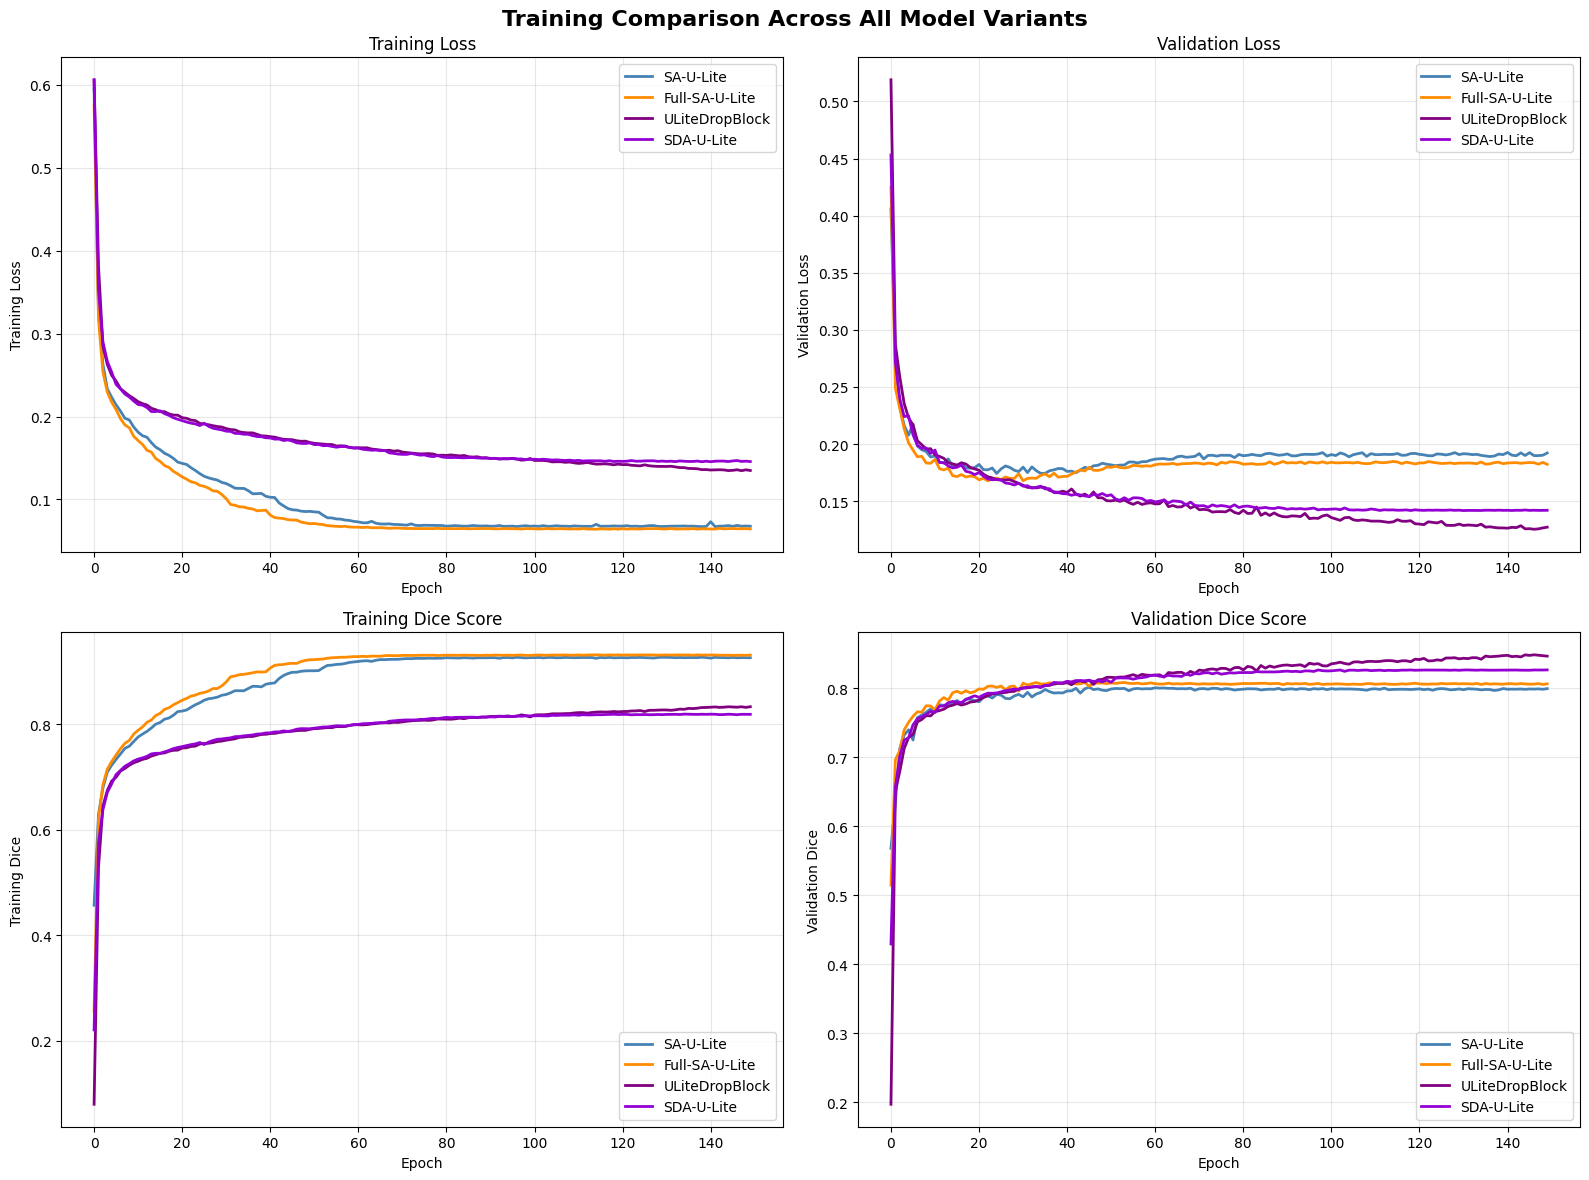

In [46]:
# Training Curves Comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Training Comparison Across All Model Variants', fontsize=16, fontweight='bold')

for model_name, results in all_results.items():
    color = MODEL_CONFIGS[model_name]['color']
    history = results['history']

    # Training Loss
    axes[0, 0].plot(history['train_loss'], label=model_name, linewidth=2, color=color)

    # Validation Loss
    axes[0, 1].plot(history['val_loss'], label=model_name, linewidth=2, color=color)

    # Training Dice
    axes[1, 0].plot(history['train_dice'], label=model_name, linewidth=2, color=color)

    # Validation Dice
    val_dice = [m['dice'] for m in history['val_metrics']]
    axes[1, 1].plot(val_dice, label=model_name, linewidth=2, color=color)

# Configure subplots
axes[0, 0].set_xlabel('Epoch'); axes[0, 0].set_ylabel('Training Loss')
axes[0, 0].set_title('Training Loss'); axes[0, 0].legend(); axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].set_xlabel('Epoch'); axes[0, 1].set_ylabel('Validation Loss')
axes[0, 1].set_title('Validation Loss'); axes[0, 1].legend(); axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].set_xlabel('Epoch'); axes[1, 0].set_ylabel('Training Dice')
axes[1, 0].set_title('Training Dice Score'); axes[1, 0].legend(); axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].set_xlabel('Epoch'); axes[1, 1].set_ylabel('Validation Dice')
axes[1, 1].set_title('Validation Dice Score'); axes[1, 1].legend(); axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [48]:
# Test Set Performance Comparison
comparison_data = []

for model_name, results in all_results.items():
    row = {'Model': model_name, 'Parameters': results['total_params']}
    for metric_name, stats in results['test_stats'].items():
        row[f'{metric_name.upper()} Mean'] = stats['mean']
        row[f'{metric_name.upper()} Std'] = stats['std']
    comparison_data.append(row)

comparison_df = pd.DataFrame(comparison_data)

print("\n" + "="*100)
print("COMPREHENSIVE MODEL COMPARISON - Test Set Results")
print("="*100)
print(comparison_df.to_string(index=False))
print("="*100)


COMPREHENSIVE MODEL COMPARISON - Test Set Results
         Model  Parameters  DICE Mean  DICE Std  IOU Mean  IOU Std  SENSITIVITY Mean  SENSITIVITY Std  SPECIFICITY Mean  SPECIFICITY Std  ACCURACY Mean  ACCURACY Std  F1 Mean   F1 Std  AUC Mean  AUC Std
     SA-U-Lite      878515   0.732252  0.026938  0.578295 0.032719          0.741777         0.048623          0.981204         0.001491       0.965967      0.004414 0.732251 0.026938  0.968063 0.007116
Full-SA-U-Lite      878613   0.732774  0.023461  0.578789 0.029065          0.744495         0.042598          0.980985         0.001100       0.965948      0.003919 0.732774 0.023461  0.968285 0.006464
ULiteDropBlock      878417   0.771789  0.019648  0.628800 0.025942          0.794492         0.034598          0.982324         0.002641       0.970371      0.004491 0.771789 0.019648  0.981866 0.003811
    SDA-U-Lite      879495   0.772485  0.016083  0.629586 0.021238          0.815525         0.023846          0.980216         0.002248 

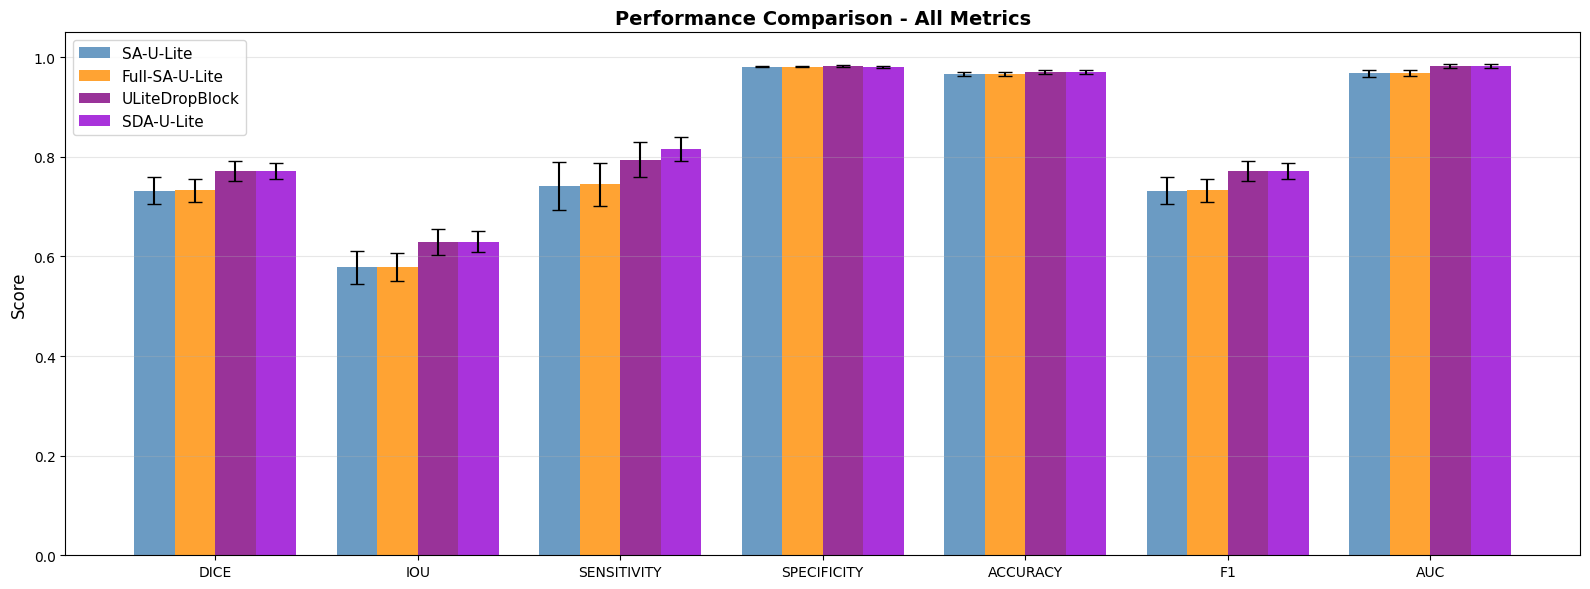

In [49]:
# Bar Chart Comparison of Key Metrics
metrics_to_plot = ['dice', 'iou', 'sensitivity', 'specificity', 'accuracy', 'f1', 'auc']
n_metrics = len(metrics_to_plot)
n_models = len(all_results)

fig, ax = plt.subplots(figsize=(16, 6))

x = np.arange(n_metrics)
width = 0.8 / n_models

for i, (model_name, results) in enumerate(all_results.items()):
    means = [results['test_stats'][m]['mean'] for m in metrics_to_plot]
    stds = [results['test_stats'][m]['std'] for m in metrics_to_plot]
    color = MODEL_CONFIGS[model_name]['color']

    offset = width * (i - (n_models - 1) / 2)
    bars = ax.bar(x + offset, means, width, label=model_name,
                  alpha=0.8, color=color, yerr=stds, capsize=5)

ax.set_ylabel('Score', fontsize=12)
ax.set_title('Performance Comparison - All Metrics', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([m.upper() for m in metrics_to_plot])
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim([0, 1.05])

plt.tight_layout()
plt.show()

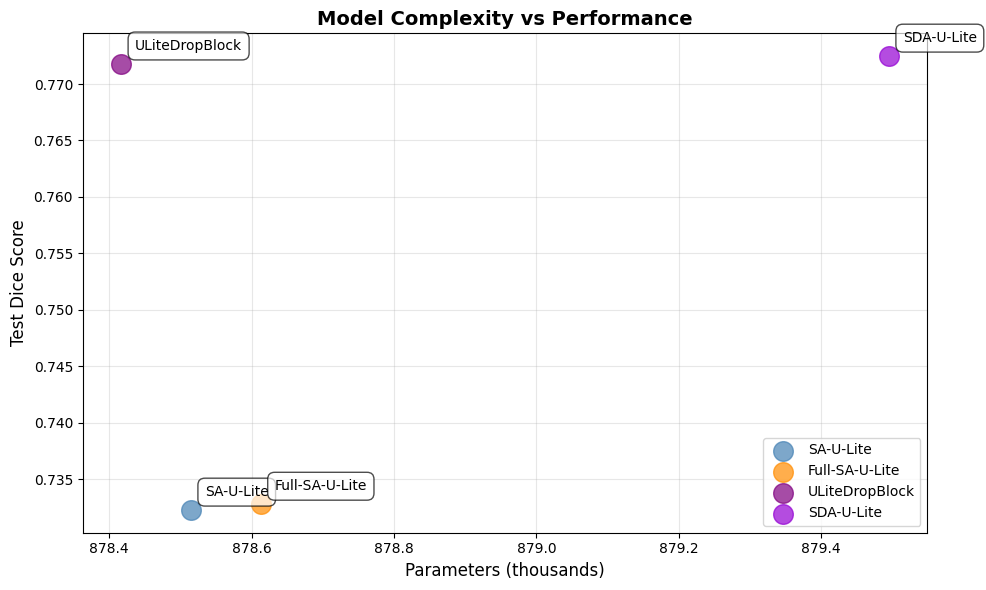

In [50]:
# Parameter Count vs Performance
fig, ax = plt.subplots(figsize=(10, 6))

for model_name, results in all_results.items():
    params = results['total_params'] / 1000  # Convert to thousands
    dice = results['test_stats']['dice']['mean']
    color = MODEL_CONFIGS[model_name]['color']

    ax.scatter(params, dice, s=200, alpha=0.7, color=color, label=model_name)
    ax.annotate(model_name, (params, dice),
                xytext=(10, 10), textcoords='offset points',
                fontsize=10, bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.7))

ax.set_xlabel('Parameters (thousands)', fontsize=12)
ax.set_ylabel('Test Dice Score', fontsize=12)
ax.set_title('Model Complexity vs Performance', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(fontsize=10)

plt.tight_layout()
plt.show()

## 8. Side-by-Side Segmentation Visualization

In [51]:
# Load all models and compare predictions
loaded_models = {}

for model_name, results in all_results.items():
    model = MODEL_CONFIGS[model_name]['class'](**MODEL_CONFIGS[model_name]['params']).to(device)
    checkpoint = torch.load(results['checkpoint_path'], weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    loaded_models[model_name] = model

print(f"Loaded {len(loaded_models)} models for comparison")

Loaded 4 models for comparison


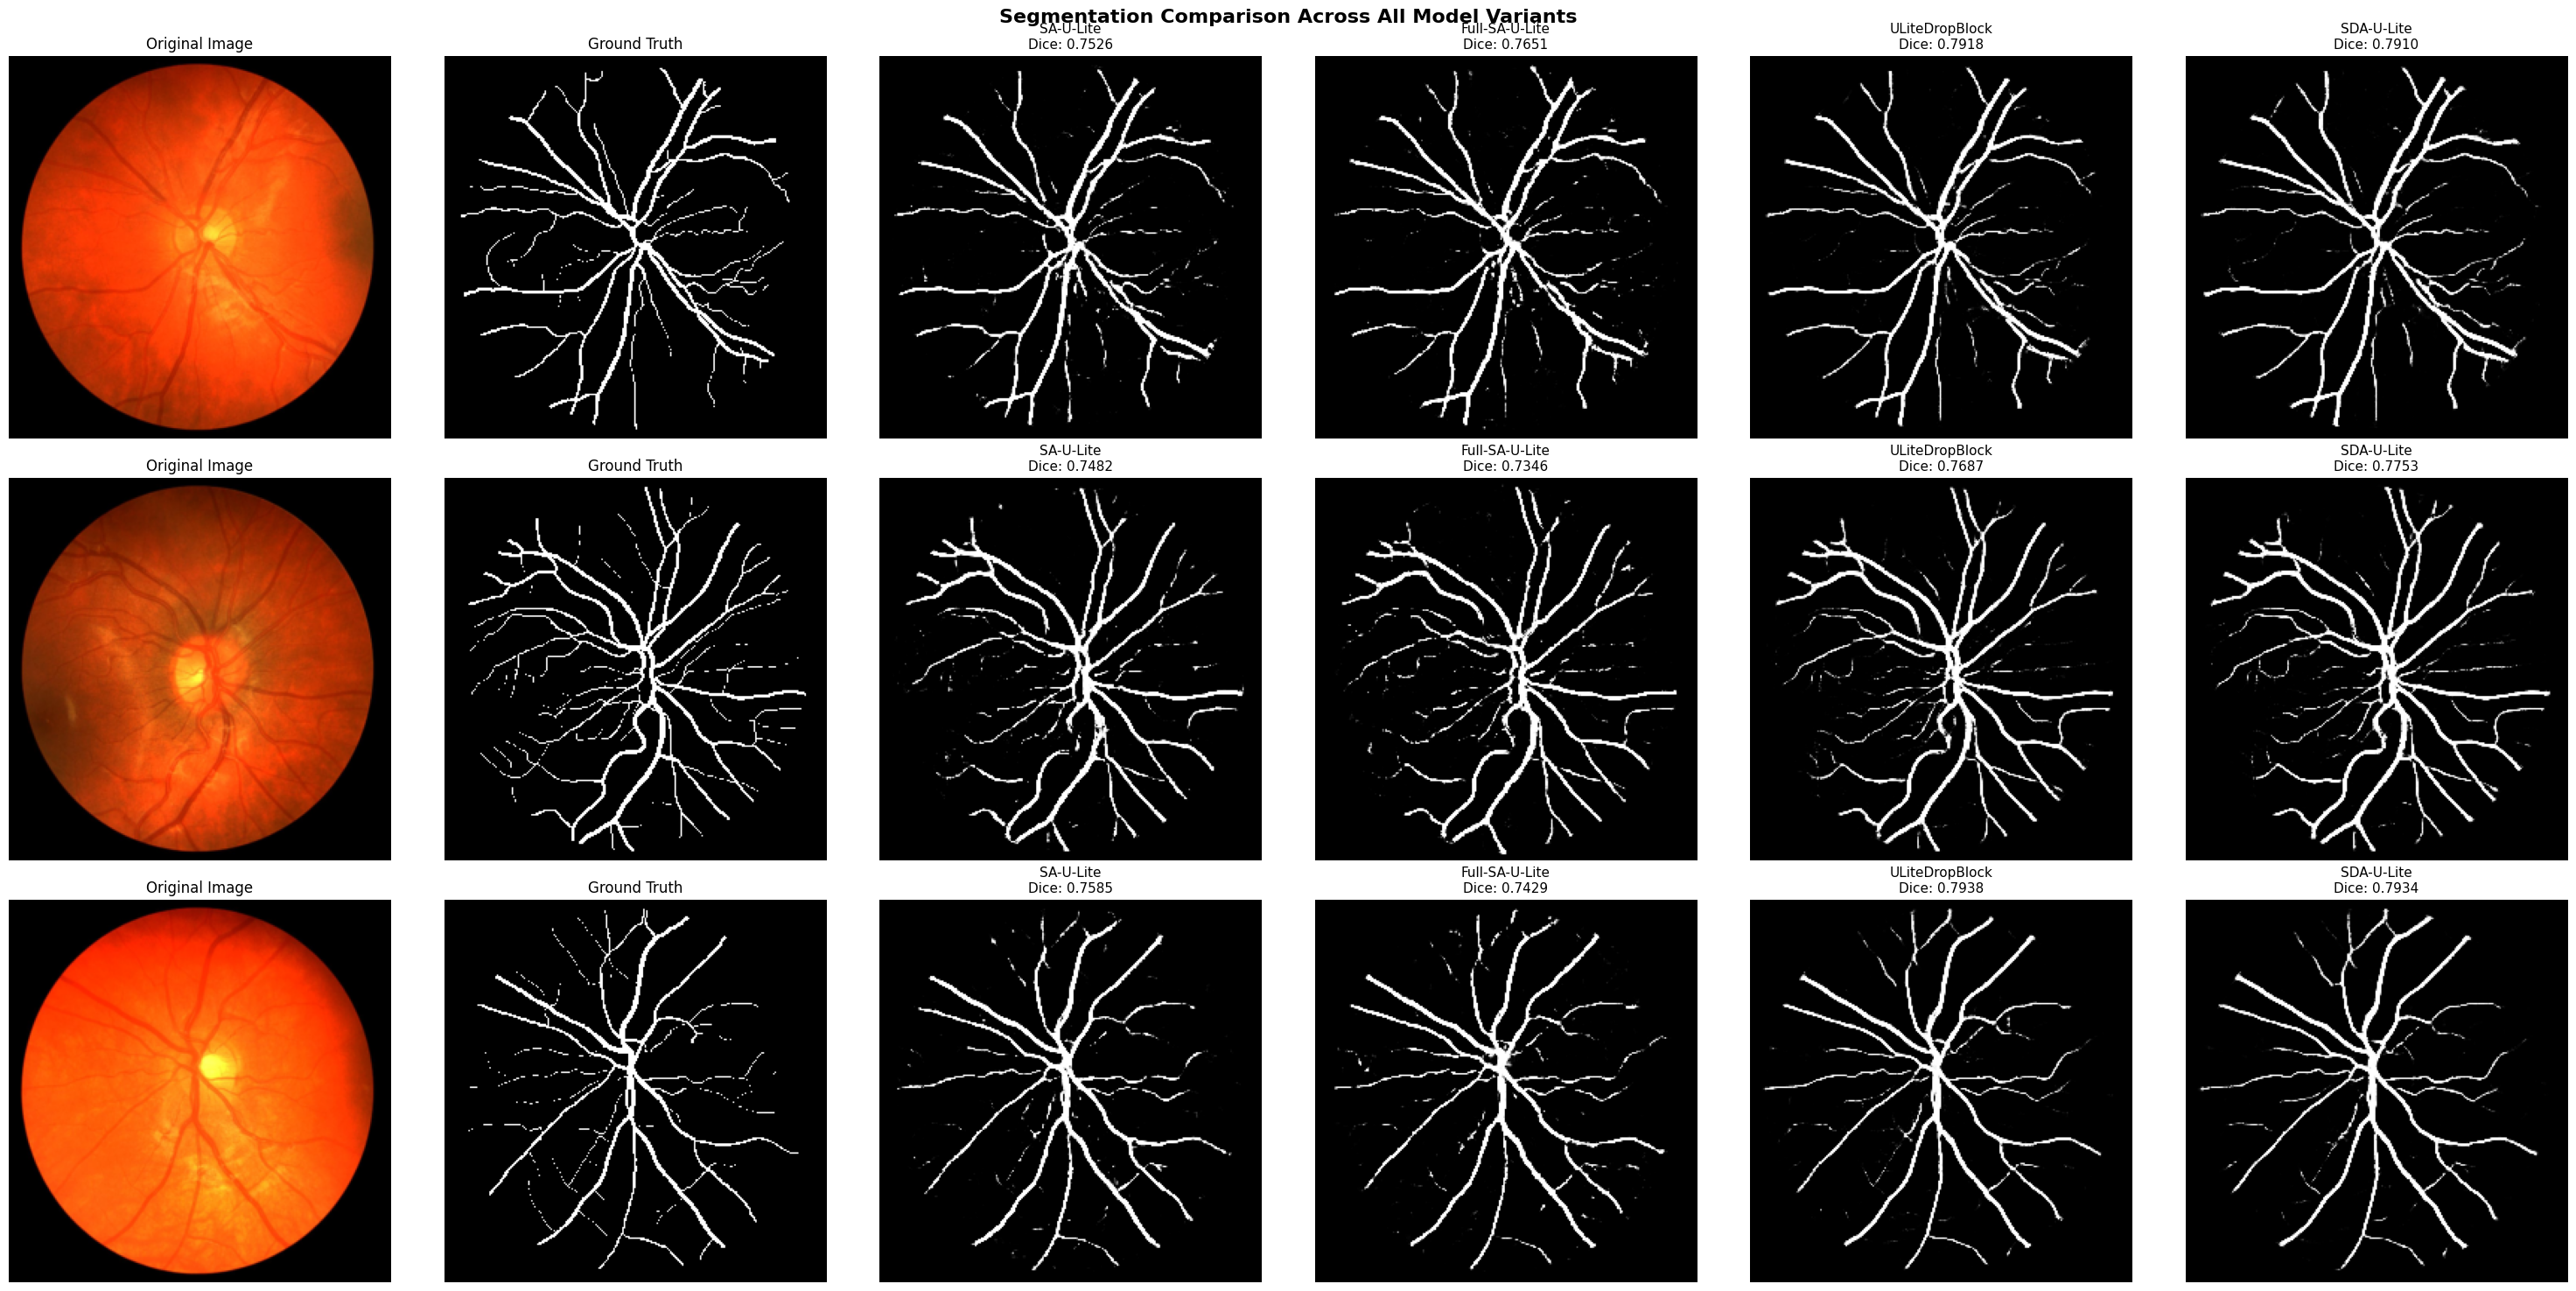

In [52]:
# Visualize predictions from all models
n_samples = 3
n_models = len(loaded_models)
sample_indices = np.random.choice(len(test_dataset), n_samples, replace=False)

fig, axes = plt.subplots(n_samples, n_models + 2, figsize=(5*(n_models+2), 5*n_samples))
if n_samples == 1:
    axes = axes.reshape(1, -1)

fig.suptitle('Segmentation Comparison Across All Model Variants', fontsize=16, fontweight='bold')

for row_idx, sample_idx in enumerate(sample_indices):
    image, mask = test_dataset[sample_idx]
    image_input = image.unsqueeze(0).to(device)

    # Original Image
    img_display = image.permute(1, 2, 0).cpu().numpy()
    axes[row_idx, 0].imshow(img_display)
    axes[row_idx, 0].set_title('Original Image', fontsize=12)
    axes[row_idx, 0].axis('off')

    # Ground Truth
    axes[row_idx, 1].imshow(mask.squeeze().cpu().numpy(), cmap='gray')
    axes[row_idx, 1].set_title('Ground Truth', fontsize=12)
    axes[row_idx, 1].axis('off')

    # Predictions from each model
    with torch.no_grad():
        for col_idx, (model_name, model) in enumerate(loaded_models.items()):
            pred = torch.sigmoid(model(image_input)).squeeze().cpu().numpy()
            dice = dice_coefficient(torch.tensor(pred > 0.5).float(), mask.squeeze())

            axes[row_idx, col_idx + 2].imshow(pred, cmap='gray')
            axes[row_idx, col_idx + 2].set_title(f'{model_name}\nDice: {dice:.4f}', fontsize=11)
            axes[row_idx, col_idx + 2].axis('off')

plt.tight_layout()
plt.show()

## 9. Export Results and Summary

In [53]:
# Save comparison results to JSON
results_summary = {
    'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'training_config': TRAINING_CONFIG,
    'models': {}
}

for model_name, results in all_results.items():
    results_summary['models'][model_name] = {
        'description': MODEL_CONFIGS[model_name]['description'],
        'parameters': results['total_params'],
        'best_val_dice': results['best_val_dice'],
        'test_metrics': {k: v['mean'] for k, v in results['test_stats'].items()},
        'test_metrics_std': {k: v['std'] for k, v in results['test_stats'].items()}
    }

# Save to file
with open('comparison_results.json', 'w') as f:
    json.dump(results_summary, f, indent=2)

print("Results saved to 'comparison_results.json'")

# Also save as CSV for easy viewing
comparison_df.to_csv('comparison_results.csv', index=False)
print("Results saved to 'comparison_results.csv'")

Results saved to 'comparison_results.json'
Results saved to 'comparison_results.csv'


In [54]:
# Final Summary
print("\n" + "="*100)
print("FINAL SUMMARY - MODEL COMPARISON")
print("="*100)

# Find best performing model
best_model = max(all_results.items(), key=lambda x: x[1]['test_stats']['dice']['mean'])
best_model_name, best_model_results = best_model

print(f"\n🏆 BEST PERFORMING MODEL: {best_model_name}")
print(f"   Description: {MODEL_CONFIGS[best_model_name]['description']}")
print(f"   Parameters: {best_model_results['total_params']:,}")
print(f"   Test Dice: {best_model_results['test_stats']['dice']['mean']:.4f} ± {best_model_results['test_stats']['dice']['std']:.4f}")
print(f"   Test IoU: {best_model_results['test_stats']['iou']['mean']:.4f} ± {best_model_results['test_stats']['iou']['std']:.4f}")

print("\n📊 ALL MODELS RANKED BY TEST DICE:")
ranked_models = sorted(all_results.items(),
                      key=lambda x: x[1]['test_stats']['dice']['mean'],
                      reverse=True)

for rank, (model_name, results) in enumerate(ranked_models, 1):
    dice_mean = results['test_stats']['dice']['mean']
    dice_std = results['test_stats']['dice']['std']
    params = results['total_params']
    print(f"   {rank}. {model_name:<25} Dice: {dice_mean:.4f} ± {dice_std:.4f}  ({params:,} params)")

print("\n💾 SAVED FILES:")
print(f"   - Model checkpoints: {TRAINING_CONFIG['save_dir']}/")
print(f"   - Comparison results: comparison_results.json")
print(f"   - Comparison CSV: comparison_results.csv")

print("\n" + "="*100)
print("COMPARISON COMPLETE!")
print("="*100)


FINAL SUMMARY - MODEL COMPARISON

🏆 BEST PERFORMING MODEL: SDA-U-Lite
   Description: U-Lite with Spatial Attention + DropBlock (Most Advanced)
   Parameters: 879,495
   Test Dice: 0.7725 ± 0.0161
   Test IoU: 0.6296 ± 0.0212

📊 ALL MODELS RANKED BY TEST DICE:
   1. SDA-U-Lite                Dice: 0.7725 ± 0.0161  (879,495 params)
   2. ULiteDropBlock            Dice: 0.7718 ± 0.0196  (878,417 params)
   3. Full-SA-U-Lite            Dice: 0.7328 ± 0.0235  (878,613 params)
   4. SA-U-Lite                 Dice: 0.7323 ± 0.0269  (878,515 params)

💾 SAVED FILES:
   - Model checkpoints: model_checkpoints/
   - Comparison results: comparison_results.json
   - Comparison CSV: comparison_results.csv

COMPARISON COMPLETE!


## 10. How to Add a New Model Variant

To add a new model variant to the comparison:

1. **Define the model class** (if it's a new architecture) in the models folder or in Section 4
2. **Add an entry to `MODEL_CONFIGS`** in Section 4:
   ```python
   'Your-Model-Name': {
       'class': YourModelClass,
       'params': {
           'input_channel': 3,
           'num_classes': 1,
           # ... other parameters
       },
       'description': 'Brief description of your model',
       'color': 'your_color'  # For visualization
   }
   ```
3. **Run Section 6** to train the new variant
4. **Run Section 7-9** to see the comparison results

That's it! The framework will automatically:
- Train your model
- Evaluate it on the test set
- Include it in all comparisons and visualizations